In [483]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_dot
from sklearn.linear_model import Ridge, LinearRegression
import networkx as nx
import pydotplus
import datetime

from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

# process mining 
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery

# viz
from pm4py.visualization.petrinet import visualizer as pn_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization

# misc 
from pm4py.objects.conversion.process_tree import converter as pt_converter

In [484]:
import xml.etree.ElementTree as Xet
import pandas as pd

### logs transformation

In [831]:
xmlparse = Xet.parse('../Downloads/known_remove.mxml')
root = xmlparse.getroot()

In [832]:
rows = []
for item in root.findall('./Process/ProcessInstance'):
    for child in item.iter():
        if child.tag == 'AuditTrailEntry':
            full_event = []
            
            if 'id' in item.attrib.keys():
                full_event.append(item.attrib['id'])
            
            skip = 0 
            
            for event in child.iter():
                #print(f'the tag is {event.tag} and attribute is {event.attrib}')
                if event.tag=='EventType' or event.tag == 'Timestamp' or event.tag =='WorkflowModelElement':
                    full_event.append(event.text)
                    
                #if event.tag=='EventType' and event.text !='complete':
                #    skip  = 1
                    
            if skip ==0:
                rows.append(full_event)    

In [833]:
df = pd.DataFrame(rows, columns = ['Id','Source','Type','Timestamp'])

In [834]:
def flat_sources(x):
    new_x = pd.DataFrame()   
    
    values = []
    
    for index, row in x.iterrows():
        values.append(pd.to_datetime(row['Timestamp']).value)
        #print(row['Timestamp'])
    
    
    noise = np.random.exponential(scale=1000)
    noise = 0
    #values.append(0)
    
    for index, row in x.iterrows():
        if row['Type'] == 'complete':
            #new_x[row['Source']] = [(pd.to_datetime(row['Timestamp']).value - min(values))/10**6 + noise]
            new_x[row['Source']] = pd.to_timedelta(pd.to_datetime(row['Timestamp']).dt.time.astype(str)).dt.total_seconds()

        #print(row['Timestamp'])
    
    
    return new_x

In [858]:
def flat_sources(x):
    new_x = pd.DataFrame()   
    
    values = []
    num = 0
    
    for index, row in x.iterrows():
        #values.append((pd.to_datetime(row['Timestamp']).hour*3600 + pd.to_datetime(row['Timestamp']).minute*60 + pd.to_datetime(row['Timestamp']).second)*10**6 + pd.to_datetime(row['Timestamp']).microsecond)
        values.append((pd.to_datetime(row['Timestamp']).value))
        
        #print(row['Timestamp'])
        num = int(row['Id'])
    #print(num)
    
    
    noise = np.random.poisson(lam = 10000, size = num)
    noise = noise.sum()
    
    #values.append(0)
    x['Timestamp'] = pd.to_datetime(x['Timestamp'])
    x['second'] = pd.to_timedelta(x['Timestamp'].dt.time.astype(str)).dt.total_seconds()

    first_row = True
    new_x['Process'] = str(num)
    
    #print(num)
    for index, row in x.iterrows():
        #if row['Type'] == 'complete':
        new_x['Process'] = str(num)
        #new_x[row['Source']] = [(pd.to_datetime(row['Timestamp']).hour*3600 + pd.to_datetime(row['Timestamp']).minute*60 + pd.to_datetime(row['Timestamp']).second)*10**6 + pd.to_datetime(row['Timestamp']).microsecond - min(values) + noise]
        new_x[row['Source']] = [((pd.to_datetime(row['Timestamp']).value) - min(values) + noise)/10**6]
            
        #new_x[row['Source']] = [(pd.to_datetime(row['second']).hour*3600 + pd.to_datetime(row['Timestamp']).minute*60 + pd.to_datetime(row['Timestamp']).second)*10**6 + pd.to_datetime(row['Timestamp']).microsecond - min(values) + noise]
            #new_x[row['Source']] = row['Timestamp'].value
        #print(row['Timestamp'])
    
    #print(new_x)
    return new_x

In [859]:
new_df = df.groupby('Id')['Id','Source','Type','Timestamp'].apply(lambda x: flat_sources(x))

/var/folders/3v/_5sm38dn1mz6tfrqwbfd9kgh0000gn/T/ipykernel_5355/803600158.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  new_df = df.groupby('Id')['Id','Source','Type','Timestamp'].apply(lambda x: flat_sources(x))


In [860]:
new_df = new_df.reset_index(drop=True)
new_df

,Process,EVENT 1 START,Accepted,Email,Archive,EVENT 2 END
0,0,0.000000,2789.000000,5176.000000,9513.000000,9513.000000
1,1,0.010013,2789.010013,4801.010013,10167.010013,10167.010013
2,10,0.099737,2758.099737,4865.099737,8904.099737,8904.099737
3,100,1.000173,2657.000173,6648.000173,8491.000173,8491.000173
4,1000,9.992538,1378.992538,4603.992538,8756.992538,8756.992538
...,...,...,...,...,...,...
9994,9994,99.944822,1529.944822,3989.944822,6548.944822,6548.944822
9995,9995,99.961210,1941.961210,5123.961210,7266.961210,7266.961210
9996,9996,99.949846,2884.949846,5908.949846,10306.949846,10306.949846
9997,9997,99.977124,1956.977124,4528.977124,8829.977124,8829.977124


In [455]:
remove = new_df[new_df['Email'].gt(new_df['Archive'])]['Process']

KeyError: 'Email'

In [ ]:
new_df[new_df['Email'].gt(new_df['Archive'])]

In [ ]:
new_df = new_df.drop(new_df[new_df.Process.isin(remove)].index)
new_df

In [861]:
del new_df['Process']

In [ ]:
df_added = new_df
df_added['Similar'] = new_df['Archive']

In [ ]:
def get_prior(new_df):
    prior_knowledge = np.eye(len(new_df.columns)) -1
    for ind1, column1 in enumerate(new_df.columns):
        for ind2, column2 in enumerate(new_df.columns):
            if column1!=column2 :
                residuals = new_df[column1] - new_df[column2]
                if (residuals >= 0).all():
                    #print(f'from {column1} to {column2} {np.where(residuals >= 0)[0]}')
                    prior_knowledge[ind2][ind1] = 0
    return prior_knowledge

In [866]:
new_df_deconfounder = new_df.drop('Accepted', axis=1)

In [647]:
new_df_deconfounder.columns

Index(['Start Event', 'Task 2', 'Task 4', 'Task 3', 'End Event'], dtype='object')

In [666]:
new_df

,EVENT 1 START,Loan,Algorithm,EVENT 2 END
0,0.0,1816.0,101816.0,102816.0
1,0.0,2217.0,102217.0,103217.0
2,0.0,1817.0,101817.0,102817.0
3,0.0,2533.0,102533.0,103533.0
4,0.0,1954.0,101954.0,102954.0
...,...,...,...,...
9994,0.0,2656.0,102656.0,103656.0
9995,0.0,2120.0,102120.0,103120.0
9996,0.0,2495.0,102495.0,103495.0
9997,0.0,1226.0,101226.0,102226.0


In [667]:
new_df

,EVENT 1 START,Loan,Algorithm,EVENT 2 END
0,0.0,1816.0,101816.0,102816.0
1,0.0,2217.0,102217.0,103217.0
2,0.0,1817.0,101817.0,102817.0
3,0.0,2533.0,102533.0,103533.0
4,0.0,1954.0,101954.0,102954.0
...,...,...,...,...
9994,0.0,2656.0,102656.0,103656.0
9995,0.0,2120.0,102120.0,103120.0
9996,0.0,2495.0,102495.0,103495.0
9997,0.0,1226.0,101226.0,102226.0


In [550]:
prior_knowledge = get_prior(new_df)

In [658]:
new_df['EVENT 2 END'] = new_df['Algorithm'] + 1000

In [852]:
new_df['EVENT 2 END'] = new_df['EVENT 2 END'] + np.random.exponential(scale=10000,size=9999)

### old LiNGAM

In [869]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression

reg = RandomForestRegressor(max_depth=10, random_state=0)
reg = Ridge()
reg = LinearRegression()

model = lingam.DirectLiNGAM()
#model = lingam.BottomUpParceLiNGAM()


model.fit(new_df_deconfounder)

/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the

### new LiNGAM with restrications on coefficents

In [867]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
import inspect
reg = RandomForestRegressor(max_depth=10, random_state=0)
reg = Ridge()
reg = LinearRegression()

model = DirectLiNGAM()
#model = lingam.BottomUpParceLiNGAM()


model.fit(new_df_deconfounder)

/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the

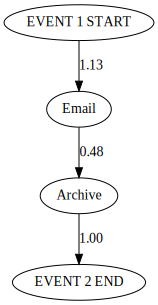

In [870]:
make_dot(model.adjacency_matrix_, labels = list(new_df_deconfounder.columns))

In [657]:
new_df

,EVENT 1 START,Loan,Algorithm,EVENT 2 END
0,0.0,1816.0,101816.0,101826.376941
1,0.0,2217.0,102217.0,102286.661069
2,0.0,1817.0,101817.0,101830.060546
3,0.0,2533.0,102533.0,102535.037052
4,0.0,1954.0,101954.0,101990.778538
...,...,...,...,...
9994,0.0,2656.0,102656.0,102697.745583
9995,0.0,2120.0,102120.0,102132.180729
9996,0.0,2495.0,102495.0,102518.717387
9997,0.0,1226.0,101226.0,101262.815400


In [1105]:
del new_df['Send Email']

In [1148]:
new_df

,Start Event,Task 1,Task 2,Task 3,Task 4,End Event
0,0.0,1148.0,2193.0,4200.0,10418.0,18232.234078
1,0.0,1594.0,3555.0,4660.0,10579.0,15790.107191
2,0.0,1134.0,2973.0,4500.0,9386.0,14402.571653
3,0.0,1408.0,3059.0,6221.0,10606.0,20948.698067
4,0.0,1881.0,3517.0,6262.0,10778.0,19295.557130
...,...,...,...,...,...,...
9994,0.0,1989.0,3028.0,5375.0,10826.0,35319.873662
9995,0.0,1782.0,3600.0,6012.0,9860.0,29056.611894
9996,0.0,1285.0,3200.0,5586.0,9814.0,12236.551189
9997,0.0,1163.0,2527.0,4729.0,9659.0,29893.472248


### trials for conditional dependence change

In [730]:
def run_conditioned(df, column_name_one, number_of_splits = 5):
    edges = []
    
    prior_knowledge = get_prior(df)
    quartile_labels = ["q"+str(quartile_number) for quartile_number in range(number_of_splits)]
    group_name_one = column_name_one+'_group'
    df[group_name_one] = pd.qcut(df[column_name_one],number_of_splits, precision=3, labels=quartile_labels)
    
    for quartile_one in quartile_labels:
        print(f'at label {quartile_one} for {column_name_one}')
        df_conditioned = df.loc[df[group_name_one] == quartile_one]
        del df_conditioned[group_name_one]

        
        print(type(df_conditioned))
        model = DirectLiNGAM(prior_knowledge=prior_knowledge)
        model.fit(df_conditioned)

        graph = make_dot(model.adjacency_matrix_, labels = list(df_conditioned.columns))

        graph.render(quartile_one+' ' + column_name_one, format='jpg',view=True)

        dotplus = pydotplus.graph_from_dot_data(graph.source)
        nx_graph = nx.nx_pydot.from_pydot(dotplus)
        
    del df[group_name_one]
    

In [735]:
new_df

,,Start Event,Task 1,Task 2,Task 3,Task 4,End Event
Id,,,,,,,
0,0,0.0,1148.0,2193.0,4200.0,10418.0,10418.443356
1,0,0.0,1594.0,3555.0,4660.0,10579.0,10579.235925
10,0,0.0,1134.0,2973.0,4500.0,9386.0,9386.290278
100,0,0.0,1408.0,3059.0,6221.0,10606.0,10607.433936
1000,0,0.0,1881.0,3517.0,6262.0,10778.0,10778.581455
...,...,...,...,...,...,...,...
9994,0,0.0,1989.0,3028.0,5375.0,10826.0,10828.209696
9995,0,0.0,1782.0,3600.0,6012.0,9860.0,9861.395348
9996,0,0.0,1285.0,3200.0,5586.0,9814.0,9814.592574


In [976]:
run_conditioned(new_df,'Accepted',4)

at label q0 for Accepted
<class 'pandas.core.frame.DataFrame'>


/var/folders/3v/_5sm38dn1mz6tfrqwbfd9kgh0000gn/T/ipykernel_5486/1183761846.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return xi - (np.cov(xi, xj)[0, 1] / np.var(xj)) * xj
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/Users/yuvaldavid/miniconda3/envs/causa

at label q1 for Accepted
<class 'pandas.core.frame.DataFrame'>


/var/folders/3v/_5sm38dn1mz6tfrqwbfd9kgh0000gn/T/ipykernel_5486/1183761846.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return xi - (np.cov(xi, xj)[0, 1] / np.var(xj)) * xj
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/Users/yuvaldavid/miniconda3/envs/causa

at label q2 for Accepted
<class 'pandas.core.frame.DataFrame'>


/var/folders/3v/_5sm38dn1mz6tfrqwbfd9kgh0000gn/T/ipykernel_5486/1183761846.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return xi - (np.cov(xi, xj)[0, 1] / np.var(xj)) * xj
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/Users/yuvaldavid/miniconda3/envs/causa

at label q3 for Accepted
<class 'pandas.core.frame.DataFrame'>


/var/folders/3v/_5sm38dn1mz6tfrqwbfd9kgh0000gn/T/ipykernel_5486/1183761846.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return xi - (np.cov(xi, xj)[0, 1] / np.var(xj)) * xj
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/Users/yuvaldavid/miniconda3/envs/causa

In [1377]:
new_df_deconfounder = new_df.drop('Accepted', axis=1)

In [1396]:
run_conditioned(new_df,'Email',4)

at label q0 for Email
<class 'pandas.core.frame.DataFrame'>


/var/folders/3v/_5sm38dn1mz6tfrqwbfd9kgh0000gn/T/ipykernel_5486/1183761846.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return xi - (np.cov(xi, xj)[0, 1] / np.var(xj)) * xj
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/Users/yuvaldavid/miniconda3/envs/causa

at label q1 for Email
<class 'pandas.core.frame.DataFrame'>


/var/folders/3v/_5sm38dn1mz6tfrqwbfd9kgh0000gn/T/ipykernel_5486/1183761846.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return xi - (np.cov(xi, xj)[0, 1] / np.var(xj)) * xj
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/Users/yuvaldavid/miniconda3/envs/causa

at label q2 for Email
<class 'pandas.core.frame.DataFrame'>


/var/folders/3v/_5sm38dn1mz6tfrqwbfd9kgh0000gn/T/ipykernel_5486/1183761846.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return xi - (np.cov(xi, xj)[0, 1] / np.var(xj)) * xj
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/Users/yuvaldavid/miniconda3/envs/causa

at label q3 for Email
<class 'pandas.core.frame.DataFrame'>


/var/folders/3v/_5sm38dn1mz6tfrqwbfd9kgh0000gn/T/ipykernel_5486/1183761846.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return xi - (np.cov(xi, xj)[0, 1] / np.var(xj)) * xj
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/Users/yuvaldavid/miniconda3/envs/causa

In [154]:
new_df_deconfounder

,,Start Event,Task 1,Task 2,End Event
Id,,,,,
0,0,0,20763000000,25627000000,25627000000
1,0,0,18247000000,30494000000,30494000000
10,0,0,28325000000,93851000000,93851000000
100,0,0,196442000000,458344000000,458344000000
1000,0,0,1731287000000,5106082000000,5106082000000
...,...,...,...,...,...
995,0,0,1714550000000,5039844000000,5039844000000
996,0,0,1721150000000,5060362000000,5060362000000
997,0,0,1722936000000,5061709000000,5061709000000


In [978]:
def run_two_conditioned(df, column_name_one, column_name_two, number_of_splits = 5):
    edges = []
    
    
    quartile_labels = ["q"+str(quartile_number) for quartile_number in range(number_of_splits)]
    group_name_one = column_name_one+'_group'
    group_name_two = column_name_two+'_group'
    df[group_name_one] = pd.qcut(df[column_name_one],number_of_splits, precision=3, labels=quartile_labels)
    df[group_name_two] = pd.qcut(df[column_name_two],number_of_splits, precision=3, labels=quartile_labels)
    
    
    for quartile_one in quartile_labels:
        for quartile_two in quartile_labels:
            print(f'at label {quartile_one} for {column_name_one}, label {quartile_two} for {column_name_two}')
            df_conditioned = df.loc[(df[group_name_one] == quartile_one) &(df[group_name_two] == quartile_two)]
            del df_conditioned[group_name_one]
            del df_conditioned[group_name_two]
            
            if not df_conditioned.empty or len(df_conditioned) > 10:
                model = lingam.DirectLiNGAM()
                model.fit(df_conditioned)

                graph = make_dot(model.adjacency_matrix_)

                graph.render(quartile_one+' ' + column_name_one + ' and '+ quartile_two+' ' + column_name_two, format='jpg',view=True)

                dotplus = pydotplus.graph_from_dot_data(graph.source)
                nx_graph = nx.nx_pydot.from_pydot(dotplus)

    del df_conditioned[group_name_one]
    del df_conditioned[group_name_two]
    del df[group_name_one]
    print('hey')
    del df[group_name_two]
    

In [979]:
run_two_conditioned(new_df,'Accepted','Send Email',3)

at label q0 for Accepted, label q0 for Send Email


/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/lingam/direct_lingam.py:220: RuntimeWarning: invalid value encountered in true_divide
  xi_std = (X[:, i] - np.mean(X[:, i])) / np.std(X[:, i])
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/lingam/direct_lingam.py:221: RuntimeWarning: invalid value encountered in true_divide
  xj_std = (X[:, j] - np.mean(X[:, j])) / np.std(X[:, j])
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/lingam/direct_lingam.py:148: RuntimeWarning: invalid value encountered in double_scalars
  return xi - (np.cov(xi, xj)[0, 1] / np.var(xj)) * xj
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeli

at label q0 for Accepted, label q1 for Send Email


/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/lingam/direct_lingam.py:220: RuntimeWarning: invalid value encountered in true_divide
  xi_std = (X[:, i] - np.mean(X[:, i])) / np.std(X[:, i])
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/lingam/direct_lingam.py:221: RuntimeWarning: invalid value encountered in true_divide
  xj_std = (X[:, j] - np.mean(X[:, j])) / np.std(X[:, j])
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/lingam/direct_lingam.py:148: RuntimeWarning: invalid value encountered in double_scalars
  return xi - (np.cov(xi, xj)[0, 1] / np.var(xj)) * xj
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeli

at label q0 for Accepted, label q2 for Send Email


/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/lingam/direct_lingam.py:220: RuntimeWarning: invalid value encountered in true_divide
  xi_std = (X[:, i] - np.mean(X[:, i])) / np.std(X[:, i])
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/lingam/direct_lingam.py:221: RuntimeWarning: invalid value encountered in true_divide
  xj_std = (X[:, j] - np.mean(X[:, j])) / np.std(X[:, j])
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/lingam/direct_lingam.py:148: RuntimeWarning: invalid value encountered in double_scalars
  return xi - (np.cov(xi, xj)[0, 1] / np.var(xj)) * xj
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeli

at label q1 for Accepted, label q0 for Send Email


/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/lingam/direct_lingam.py:220: RuntimeWarning: invalid value encountered in true_divide
  xi_std = (X[:, i] - np.mean(X[:, i])) / np.std(X[:, i])
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/lingam/direct_lingam.py:221: RuntimeWarning: invalid value encountered in true_divide
  xj_std = (X[:, j] - np.mean(X[:, j])) / np.std(X[:, j])
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/lingam/direct_lingam.py:148: RuntimeWarning: invalid value encountered in double_scalars
  return xi - (np.cov(xi, xj)[0, 1] / np.var(xj)) * xj
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeli

at label q1 for Accepted, label q1 for Send Email


/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/lingam/direct_lingam.py:220: RuntimeWarning: invalid value encountered in true_divide
  xi_std = (X[:, i] - np.mean(X[:, i])) / np.std(X[:, i])
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/lingam/direct_lingam.py:221: RuntimeWarning: invalid value encountered in true_divide
  xj_std = (X[:, j] - np.mean(X[:, j])) / np.std(X[:, j])
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/lingam/direct_lingam.py:148: RuntimeWarning: invalid value encountered in double_scalars
  return xi - (np.cov(xi, xj)[0, 1] / np.var(xj)) * xj
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeli

at label q1 for Accepted, label q2 for Send Email


/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/lingam/direct_lingam.py:220: RuntimeWarning: invalid value encountered in true_divide
  xi_std = (X[:, i] - np.mean(X[:, i])) / np.std(X[:, i])
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/lingam/direct_lingam.py:221: RuntimeWarning: invalid value encountered in true_divide
  xj_std = (X[:, j] - np.mean(X[:, j])) / np.std(X[:, j])
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/lingam/direct_lingam.py:148: RuntimeWarning: invalid value encountered in double_scalars
  return xi - (np.cov(xi, xj)[0, 1] / np.var(xj)) * xj
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeli

at label q2 for Accepted, label q0 for Send Email
at label q2 for Accepted, label q1 for Send Email


/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/lingam/direct_lingam.py:220: RuntimeWarning: invalid value encountered in true_divide
  xi_std = (X[:, i] - np.mean(X[:, i])) / np.std(X[:, i])
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/lingam/direct_lingam.py:221: RuntimeWarning: invalid value encountered in true_divide
  xj_std = (X[:, j] - np.mean(X[:, j])) / np.std(X[:, j])
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/lingam/direct_lingam.py:148: RuntimeWarning: invalid value encountered in double_scalars
  return xi - (np.cov(xi, xj)[0, 1] / np.var(xj)) * xj
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeli

at label q2 for Accepted, label q2 for Send Email


/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/lingam/direct_lingam.py:220: RuntimeWarning: invalid value encountered in true_divide
  xi_std = (X[:, i] - np.mean(X[:, i])) / np.std(X[:, i])
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/lingam/direct_lingam.py:221: RuntimeWarning: invalid value encountered in true_divide
  xj_std = (X[:, j] - np.mean(X[:, j])) / np.std(X[:, j])
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/lingam/direct_lingam.py:148: RuntimeWarning: invalid value encountered in double_scalars
  return xi - (np.cov(xi, xj)[0, 1] / np.var(xj)) * xj
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeli

KeyError: 'Accepted_group'

In [307]:
del new_df['Task 2_group']

In [871]:
new_df

,EVENT 1 START,Accepted,Email,Archive,EVENT 2 END
0,0.000000,2789.000000,5176.000000,9513.000000,9513.000000
1,0.010013,2789.010013,4801.010013,10167.010013,10167.010013
2,0.099737,2758.099737,4865.099737,8904.099737,8904.099737
3,1.000173,2657.000173,6648.000173,8491.000173,8491.000173
4,9.992538,1378.992538,4603.992538,8756.992538,8756.992538
...,...,...,...,...,...
9994,99.944822,1529.944822,3989.944822,6548.944822,6548.944822
9995,99.961210,1941.961210,5123.961210,7266.961210,7266.961210
9996,99.949846,2884.949846,5908.949846,10306.949846,10306.949846
9997,99.977124,1956.977124,4528.977124,8829.977124,8829.977124


### trials for unobserved confounder

In [908]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

x0_fit = new_df['Email'].to_numpy().reshape(-1, 1)
x1_fit = new_df['Archive'].to_numpy().reshape(-1, 1)
x_fit = new_df['Accepted'].to_numpy().reshape(-1, 1)

reg_1 = LinearRegression().fit(x0_fit,x1_fit)
reg_2 = LinearRegression().fit(x1_fit,x0_fit)
reg_1_real = LinearRegression().fit(x_fit,x1_fit)
reg_2_real = LinearRegression().fit(x_fit,x0_fit)
reg_1_real_op = LinearRegression().fit(x1_fit,x_fit)
reg_2_real_op = LinearRegression().fit(x0_fit,x_fit)

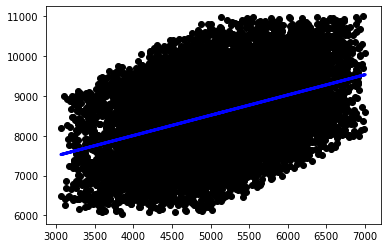

986244.18969776
1.5717640210657266e-13


In [876]:
import matplotlib.pyplot as plt

pred = reg_1.predict(x0_fit)

plt.scatter(x0_fit, x1_fit, color="black")
plt.plot(x0_fit, pred, color="blue", linewidth=3)


plt.show()


print(np.std((pred-x1_fit)**2))
print(np.mean(pred-x1_fit))

### True

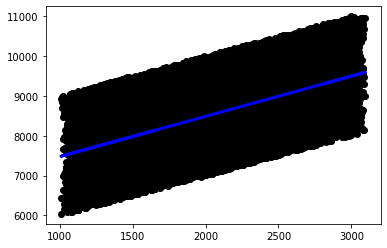

670392.552359715
-9.459690867525206e-15


In [877]:
import matplotlib.pyplot as plt

pred = reg_1_real.predict(x_fit)

plt.scatter(x_fit, x1_fit, color="black")
plt.plot(x_fit, pred, color="blue", linewidth=3)


plt.show()


print(np.std((pred-x1_fit)**2))
print(np.mean(pred-x1_fit))

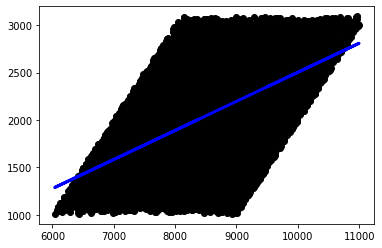

264610.7494603769
-4.0021769054914336e-14


In [911]:
import matplotlib.pyplot as plt

pred = reg_1_real_op.predict(x1_fit)

plt.scatter(x1_fit, x_fit, color="black")
plt.plot(x1_fit, pred, color="blue", linewidth=3)


plt.show()


print(np.std((pred-x_fit)**2))
print(np.mean(pred-x_fit))

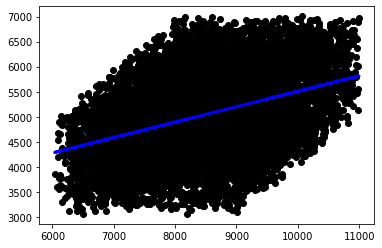

675622.5952247112
612.4238717601106


In [931]:
import matplotlib.pyplot as plt

pred = reg_2.predict(x1_fit)

plt.scatter(x1_fit, x0_fit, color="black")
plt.plot(x1_fit, pred, color="blue", linewidth=3)

plt.show()

print(np.std((pred-x0_fit)**2))
print(np.mean(np.abs(pred-x0_fit)))

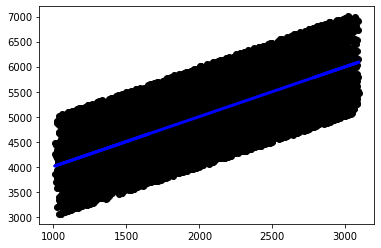

298025.8883325634
500.27876622713603


In [932]:
import matplotlib.pyplot as plt

pred = reg_2_real.predict(x_fit)

plt.scatter(x_fit, x0_fit, color="black")
plt.plot(x_fit, pred, color="blue", linewidth=3)

plt.show()

print(np.std((pred-x0_fit)**2))
print(np.mean(np.abs(pred-x0_fit)))

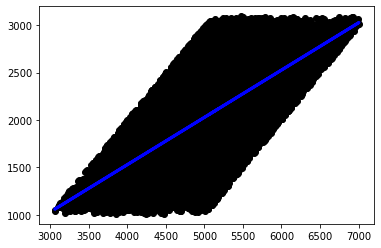

198461.8355112236
333.9313220530053


In [933]:
import matplotlib.pyplot as plt

pred = reg_2_real_op.predict(x0_fit)

plt.scatter(x0_fit, x_fit, color="black")
plt.plot(x0_fit, pred, color="blue", linewidth=3)


plt.show()


print(np.std((pred-x_fit)**2))
print(np.mean(np.abs(pred-x_fit)))

In [880]:
res_x0 = reg_1.predict(x0_fit) - x1_fit
res_x1 = reg_2.predict(x1_fit) - x0_fit

In [902]:
if np.min(res_x0) < 0:
    res_x0 = res_x0 - np.min(res_x0)
if np.min(res_x1) < 0:
    res_x1 = res_x1 - np.min(res_x1)
    

In [896]:
res_x0_real = reg_1_real.predict(x_fit) - x1_fit
res_x1_real = reg_2_real.predict(x_fit) - x0_fit

In [904]:
hoeffding(x0_fit[:,0], res_x1[:,0])

0.4406738248787684

In [905]:
import scipy

hoeffding(x1_fit[:,0], res_x0[:,0])

0.4573775358864171

In [906]:
scipy.stats.spearmanr(x1_fit[:,0], res_x0[:,0])

SpearmanrResult(correlation=-0.9204826346847528, pvalue=0.0)

In [907]:
from sklearn.feature_selection import mutual_info_regression

# reshape necessary because the function accepts many
# features at once to be compared with the right-hand side
print(mutual_info_regression(x0_fit, res_x1))
print(mutual_info_regression(x1_fit, res_x0))

[0.96854284]
[0.9466692]


In [897]:
from sklearn.feature_selection import mutual_info_regression

# reshape necessary because the function accepts many
# features at once to be compared with the right-hand side
print(mutual_info_regression(x0_fit, res_x1_real))
print(mutual_info_regression(x1_fit, res_x0_real))

[0.46416781]
[0.71542603]


In [898]:
hoeffding(x0_fit[:,0], res_x1_real[:,0])

0.17410223410086256

In [899]:
hoeffding(x1_fit[:,0], res_x0_real[:,0])

0.30117429907494137

In [901]:
scipy.stats.spearmanr(x1_fit[:,0], res_x0_real[:,0])

SpearmanrResult(correlation=-0.8355517187805996, pvalue=0.0)

In [934]:
def run_q_regression(df, column_name_one, column_name_two, number_of_splits = 5):
    edges = []
    
    
    quartile_labels = ["q"+str(quartile_number) for quartile_number in range(number_of_splits)]
    group_name_one = column_name_one+'_group'
    df[group_name_one] = pd.qcut(df[column_name_one],number_of_splits, precision=3, labels=quartile_labels)
    
    
    quartile_one = 'q3'
    df_conditioned = df.loc[(df[group_name_one] == quartile_one)]
    
    del df_conditioned[group_name_one]
    
    x_fit = df_conditioned[column_name_one].to_numpy().reshape(-1, 1)
    y_fit = df_conditioned[column_name_two].to_numpy().reshape(-1, 1)

    reg_1 = LinearRegression().fit(x_fit,y_fit)
    reg_1_real = LinearRegression().fit(y_fit,x_fit)
    

    pred = reg_1.predict(x_fit)

    plt.scatter(x_fit, y_fit, color="black")
    plt.plot(x_fit, pred, color="blue", linewidth=3)

    plt.show()

    print(np.std((pred-y_fit)**2))
    print(np.mean(np.abs(pred-y_fit)))

    
    pred = reg_1_real.predict(y_fit)

    plt.scatter(y_fit, x_fit, color="black")
    plt.plot(y_fit, pred, color="blue", linewidth=3)

    plt.show()

    print(np.std((pred-x_fit)**2))
    print(np.mean(np.abs(pred-x_fit)))

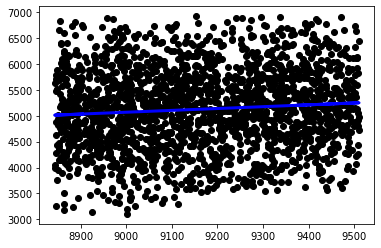

718462.9578586859
626.5677401900508


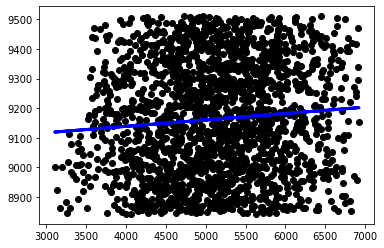

32412.75923907276
164.10404105185577


In [935]:
run_q_regression(new_df,'Archive','Email')

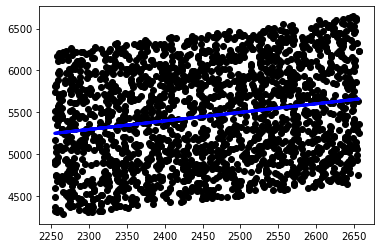

295618.2573278854
508.0188188618369


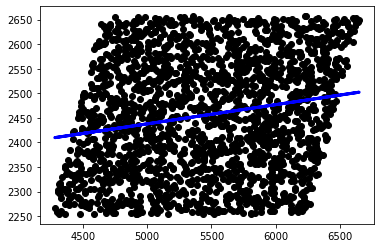

12467.366041079258
97.6858653429634


In [936]:
run_q_regression(new_df,'Accepted','Email',number_of_splits=5)

In [882]:
import pandas as pd
import numpy as np
from scipy.stats import rankdata
from scipy.signal import decimate
import math
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

def hoeffding(*arg):
  
    if(len(arg)==1):
      if isinstance(arg[0], pd.DataFrame):
        if(arg[0].shape[0]>1):
          return arg[0].apply(lambda x: arg[0].apply(lambda y: hoeffding(x.values, y.values)))
    else:
      if(len(arg)==2):
        if type(arg[0]) is not np.ndarray:
          if (len(arg[0].shape)>1):
            return print("ERROR inputs : hoeffding(df >2col) or hoeffding(numpy.array -1d- ,numpy.array -1d-)")
        if type(arg[1]) is np.ndarray:
          if (len(arg[0].shape)>1):
            return print("ERROR inputs : hoeffding(df >2col) or hoeffding(numpy.array -1d- ,numpy.array -1d-)")
        
        xin=arg[0]
        yin=arg[1]
        #crop data to the smallest array, length have to be equal
        if len(xin)<len(yin):
          yin=yin[:len(xin)]
        if len(xin)>len(yin):
          xin=xin[:len(yin)]

        # dropna
        x = xin[~(np.isnan(xin) | np.isnan(yin))]
        y = yin[~(np.isnan(xin) | np.isnan(yin))]

        # undersampling if length too long
        lenx=len(x)
        if lenx>99999:
            factor=math.ceil(lenx/100000)
            x=x[::factor]
            y=y[::factor]

        # bining if too much "definition"
        if len(np.unique(x))>50:
            est = KBinsDiscretizer(n_bins=50, encode='ordinal', strategy='quantile') #faster strategy='quantile' but less accurate
            est.fit(x.reshape(-1, 1))  
            Rtemp = est.transform(x.reshape(-1, 1))
            R=rankdata(Rtemp)
        else:
            R=rankdata(x)
        if len(np.unique(y))>50:
            est1 = KBinsDiscretizer(n_bins=50, encode='ordinal', strategy='quantile') #faster strategy='quantile' but less accurate
            est1.fit(y.reshape(-1, 1))  
            Stemp = est1.transform(y.reshape(-1, 1))
            S=rankdata(Stemp)
        else:
            S=rankdata(y)      

        # core processing
        N=x.shape
        dico={(np.nan,np.nan):np.nan}
        dicoRin={np.nan:np.nan}
        dicoSin={np.nan:np.nan}
        dicoRless={np.nan:np.nan}
        dicoSless={np.nan:np.nan}
        Q=np.ones(N[0])

        i=0;
        for r,s in np.nditer([R,S]):
            r=float(r)
            s=float(s)
            if (r,s) in dico.keys():
                Q[i]=dico[(r,s)]
            else:
              if r in dicoRin.keys():
                  isinR=dicoRin[r]
                  lessR=dicoRless[r]
              else:
                  isinR=np.isin(R,r)
                  dicoRin[r]=isinR
                  lessR=np.less(R,r)
                  dicoRless[r]=lessR

              if s in dicoSin.keys():
                  isinS=dicoSin[s]
                  lessS=dicoSless[s]
              else:
                  isinS=np.isin(S,s)
                  dicoSin[s]=isinS
                  lessS=np.less(S,s)
                  dicoSless[s]=lessS


              Q[i] = Q[i] + np.count_nonzero(lessR & lessS) \
                    + 1/4 * (np.count_nonzero(isinR & isinS)-1) \
                    + 1/2 * (np.count_nonzero(isinR & lessS)) \
                     + 1/2 * (np.count_nonzero(lessR & isinS)) 
              dico[(r,s)]=Q[i]
            i+=1

        D1 = np.sum( np.multiply((Q-1),(Q-2)) );
        D2 = np.sum( np.multiply(np.multiply((R-1),(R-2)),np.multiply((S-1),(S-2)) ) );
        D3 = np.sum( np.multiply(np.multiply((R-2),(S-2)),(Q-1)) );

        D = 30*((N[0]-2)*(N[0]-3)*D1 + D2 - 2*(N[0]-2)*D3) / (N[0]*(N[0]-1)*(N[0]-2)*(N[0]-3)*(N[0]-4));


        return D
      return print("ERROR inputs : hoeffding(df >2col) or hoeffding(numpy.array -1d- ,numpy.array -1d-)")

### our LiNGAM

In [16]:
import graphviz
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LassoLarsIC
from sklearn.utils import check_array

import igraph as ig
from scipy.special import expit as sigmoid
import random


__all__ = [
    "print_causal_directions",
    "print_dagc",
    "make_prior_knowledge",
    "remove_effect",
    "make_dot",
    "predict_adaptive_lasso",
    "get_sink_variables",
    "get_exo_variables",
    "find_all_paths",
    "simulate_dag",
    "simulate_parameter",
    "simulate_linear_sem",
    "count_accuracy",
    "set_random_seed",
]


def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)


def simulate_linear_sem(adjacency_matrix, n_samples, sem_type, noise_scale=1.0):
    """Simulate samples from linear SEM with specified type of noise.
    Parameters
    ----------
    adjacency_matrix : array-like, shape (n_features, n_features)
        Weighted adjacency matrix of DAG, where ``n_features``
        is the number of variables.
    n_samples : int
        Number of samples. n_samples=inf mimics population risk.
    sem_type : str
        SEM type. gauss, exp, gumbel, logistic, poisson.
    noise_scale : float
        scale parameter of additive noise.
    Returns
    -------
    X : array-like, shape (n_samples, n_features)
        Data generated from linear SEM with specified type of noise,
        where ``n_features`` is the number of variables.
    """
    def _simulate_single_equation(X, w):
        """Simulate samples from a single equation.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features_parents)
            Data of parents for a specified variable, where
            n_features_parents is the number of parents.
        w : array-like, shape (1, n_features_parents)
            Weights of parents.
        Returns
        -------
        x : array-like, shape (n_samples, 1)
            Data for the specified variable.
        """
        if sem_type == 'gauss':
            z = np.random.normal(scale=noise_scale, size=n_samples)
            x = X @ w + z
        elif sem_type == 'exp':
            z = np.random.exponential(scale=noise_scale, size=n_samples)
            x = X @ w + z
        elif sem_type == 'gumbel':
            z = np.random.gumbel(scale=noise_scale, size=n_samples)
            x = X @ w + z
        elif sem_type == 'logistic':
            x = np.random.binomial(1, sigmoid(X @ w)) * 1.0
        elif sem_type == 'poisson':
            x = np.random.poisson(np.exp(X @ w)) * 1.0
        elif sem_type == 'subGaussian':
            z = np.random.normal(scale=noise_scale, size=n_samples)
            q = 0.5 + 0.3 * np.random.rand(1)  # sub-Gaussian
            z = np.sign(z) * pow(np.abs(z), q)
            z = z - np.mean(z)
            z = z / np.std(z)
            x = X @ w + z
        elif sem_type == 'supGaussian':
            z = np.random.normal(scale=noise_scale, size=n_samples)
            q = 1.2 + 0.8 * np.random.rand(1)  # super-Gaussian
            z = np.sign(z) * pow(np.abs(z), q)
            z = z - np.mean(z)
            z = z / np.std(z)
            x = X @ w + z
        elif sem_type == 'nonGaussian':
            z = np.random.normal(scale=noise_scale, size=n_samples)
            qq = -1
            if qq == 1:
                q = 0.5 + 0.3 * np.random.rand(1)  # sub-Gaussian
            else:
                q = 1.2 + 0.8 * np.random.rand(1)  # super-Gaussian
            z = np.sign(z) * pow(np.abs(z), q)
            z = z - np.mean(z)
            z = z / np.std(z)
            x = X @ w + z
        elif sem_type == 'uniform':
            z = np.random.uniform(0, 1, n_samples)
            z = z - np.mean(z)
            z = z / np.std(z)
            x = X @ w + z
        elif sem_type == 'gamma':
            z = np.random.gamma(2, 2, n_samples)
            z = z - np.mean(z)
            z = z / np.std(z)
            x = X @ w + z
        elif sem_type == 'laplace':
            z = np.random.laplace(0, scale=noise_scale, size=n_samples)
            x = X @ w + z
        else:
            raise ValueError('unknown sem type')
        return x

    n_features = adjacency_matrix.shape[0]
    if np.isinf(n_samples):
        if sem_type == 'gauss':
            # make 1/n_features X'X = true cov
            X = np.sqrt(n_features) * noise_scale * np.linalg.pinv(np.eye(n_features) - adjacency_matrix)
            return X
        else:
            raise ValueError('population risk not available')
    X = np.zeros([n_samples, n_features])

    G = ig.Graph.Weighted_Adjacency(adjacency_matrix.tolist())
    ordered_vertices = G.topological_sorting()
    assert len(ordered_vertices) == n_features

    for j in ordered_vertices:
        parents = G.neighbors(j, mode=ig.IN)
        X[:, j] = _simulate_single_equation(X[:, parents], adjacency_matrix[parents, j])
    return X


def count_accuracy(W_true, W, W_und=None):
    """Compute recalls and precisions for W, or optionally for CPDAG = W + W_und.
    Parameters
    ----------
    W_true : array-like, shape (n_features, n_features)
        Ground truth graph, where ``n_features`` is
        the number of features.
    W : array-like, shape (n_features, n_features)
        Predicted graph.
    W_und : array-like, shape (n_features, n_features)
        Predicted undirected edges in CPDAG, asymmetric.
    Returns
    -------
    recall : float
        (true positive) / (true positive + false negative).
    precision : float
        (true positive) / (true positive + false positive).
    """
    # convert to binary adjacency matrix
    B_true = (W_true != 0)
    B = (W != 0)
    B_und = None if W_und is None else (W_und != 0)
    # linear index of nonzeros
    pred_und = None
    if B_und is not None:
        pred_und = np.flatnonzero(B_und)
    pred = np.flatnonzero(B)
    cond = np.flatnonzero(B_true)
    cond_reversed = np.flatnonzero(B_true.T)
    cond_skeleton = np.concatenate([cond, cond_reversed])
    # true pos
    true_pos = np.intersect1d(pred, cond, assume_unique=True)
    if B_und is not None:
        # treat undirected edge favorably
        true_pos_und = np.intersect1d(pred_und, cond_skeleton, assume_unique=True)
        true_pos = np.concatenate([true_pos, true_pos_und])
    # false pos
    false_pos = np.setdiff1d(pred, cond_skeleton, assume_unique=True)
    if B_und is not None:
        false_pos_und = np.setdiff1d(pred_und, cond_skeleton, assume_unique=True)
        false_pos = np.concatenate([false_pos, false_pos_und])
    # reverse
    # extra = np.setdiff1d(pred, cond, assume_unique=True)
    # compute ratio
    pred_size = len(pred)
    if B_und is not None:
        pred_size += len(pred_und)
    # fdr = float(len(reverse) + len(false_pos)) / max(pred_size, 1)
    tpr = float(len(true_pos)) / max(len(cond), 1)
    # fpr = float(len(reverse) + len(false_pos)) / max(cond_neg_size, 1)

    recall = tpr
    precision = float(len(true_pos)) / max(pred_size, 1)

    return recall, precision


def simulate_parameter(B, w_ranges=((-2.0, -0.5), (0.5, 2.0))):
    """Simulate SEM parameters for a DAG.
    Parameters
    ----------
    B : array-like, shape (n_features, n_features)
        Binary adjacency matrix of DAG, where ``n_features``
        is the number of features.
    w_ranges : tuple
        Disjoint weight ranges.
    Returns
    -------
    adjacency_matrix : array-like, shape (n_features, n_features)
        Weighted adj matrix of DAG, where ``n_features``
        is the number of features.
    """

    adjacency_matrix = np.zeros(B.shape)
    S = np.random.randint(len(w_ranges), size=B.shape)  # which range
    for i, (low, high) in enumerate(w_ranges):
        U = np.random.uniform(low=low, high=high, size=B.shape)
        adjacency_matrix += B * (S == i) * U
    return adjacency_matrix


def simulate_dag(n_features, n_edges, graph_type):
    """Simulate random DAG with some expected number of edges.
    Parameters
    ----------
    n_features : int
        Number of features.
    n_edges : int
        Expected number of edges.
    graph_type : str
        ER, SF.
    Returns
    -------
    B : array-like, shape (n_features, n_features)
        binary adjacency matrix of DAG.
    """
    def _random_permutation(M):
        # np.random.permutation permutes first axis only
        P = np.random.permutation(np.eye(M.shape[0]))
        return P.T @ M @ P

    def _random_acyclic_orientation(B_und):
        return np.tril(_random_permutation(B_und), k=-1)

    def _graph_to_adjmat(G):
        return np.array(G.get_adjacency().data)

    if graph_type == 'ER':
        # Erdos-Renyi
        G_und = ig.Graph.Erdos_Renyi(n=n_features, m=n_edges)
        B_und = _graph_to_adjmat(G_und)
        B = _random_acyclic_orientation(B_und)
    elif graph_type == 'SF':
        # Scale-free, Barabasi-Albert
        G = ig.Graph.Barabasi(n=n_features, m=int(round(n_edges / n_features)), directed=True)
        B = _graph_to_adjmat(G)
    elif graph_type == 'BP':
        # Bipartite, Sec 4.1 of (Gu, Fu, Zhou, 2018)
        top = int(0.2 * n_features)
        G = ig.Graph.Random_Bipartite(top, n_features - top, m=n_edges, directed=True, neimode=ig.OUT)
        B = _graph_to_adjmat(G)
    else:
        raise ValueError('unknown graph type')
    B_perm = _random_permutation(B)
    assert ig.Graph.Adjacency(B_perm.tolist()).is_dag()
    return B_perm


def print_causal_directions(cdc, n_sampling, labels=None):
    """Print causal directions of bootstrap result to stdout.
    Parameters
    ----------
    cdc : dict
        List of causal directions sorted by count in descending order.
        This can be set the value returned by ``BootstrapResult.get_causal_direction_counts()`` method.
    n_sampling : int
        Number of bootstrapping samples.
    labels : array-like, optional (default=None)
        List of feature lables.
        If set labels, the output feature name will be the specified label.
    """
    for i, (fr, to, co) in enumerate(zip(cdc["from"], cdc["to"], cdc["count"])):
        sign = "" if "sign" not in cdc else "(b>0)" if cdc["sign"][i] > 0 else "(b<0)"
        if labels:
            print(f"{labels[to]} <--- {labels[fr]} {sign} ({100*co/n_sampling:.1f}%)")
        else:
            print(f"x{to} <--- x{fr} {sign} ({100*co/n_sampling:.1f}%)")


def print_dagc(dagc, n_sampling, labels=None):
    """Print DAGs of bootstrap result to stdout.
    Parameters
    ----------
    dagc : dict
        List of directed acyclic graphs sorted by count in descending order.
        This can be set the value returned by ``BootstrapResult.get_directed_acyclic_graph_counts()`` method.
    n_sampling : int
        Number of bootstrapping samples.
    labels : array-like, optional (default=None)
        List of feature lables.
        If set labels, the output feature name will be the specified label.
    """
    for i, (dag, co) in enumerate(zip(dagc["dag"], dagc["count"])):
        print(f"DAG[{i}]: {100*co/n_sampling:.1f}%")
        for j, (fr, to) in enumerate(zip(dag["from"], dag["to"])):
            sign = "" if "sign" not in dag else "(b>0)" if dag["sign"][j] > 0 else "(b<0)"
            if labels:
                print("\t" + f"{labels[to]} <--- {labels[fr]} {sign}")
            else:
                print("\t" + f"x{to} <--- x{fr} {sign}")


def make_prior_knowledge(
    n_variables,
    exogenous_variables=None,
    sink_variables=None,
    paths=None,
    no_paths=None,
):
    """Make matrix of prior knowledge.
    Parameters
    ----------
    n_variables : int
        Number of variables.
    exogenous_variables : array-like, shape (index, ...), optional (default=None)
        List of exogenous variables(index).
        Prior knowledge is created with the specified variables as exogenous variables.
    sink_variables : array-like, shape (index, ...), optional (default=None)
        List of sink variables(index).
        Prior knowledge is created with the specified variables as sink variables.
    paths : array-like, shape ((index, index), ...), optional (default=None)
        List of variables(index) pairs with directed path.
        If ``(i, j)``, prior knowledge is created that xi has a directed path to xj.
    no_paths : array-like, shape ((index, index), ...), optional (default=None)
        List of variables(index) pairs without directed path.
        If ``(i, j)``, prior knowledge is created that xi does not have a directed path to xj.
    Returns
    -------
    prior_knowledge : array-like, shape (n_variables, n_variables)
        Return matrix of prior knowledge used for causal discovery.
    """
    prior_knowledge = np.full((n_variables, n_variables), -1)
    if no_paths:
        for no_path in no_paths:
            prior_knowledge[no_path[1], no_path[0]] = 0
    if paths:
        for path in paths:
            prior_knowledge[path[1], path[0]] = 1
    if sink_variables:
        for var in sink_variables:
            prior_knowledge[:, var] = 0
    if exogenous_variables:
        for var in exogenous_variables:
            prior_knowledge[var, :] = 0
    np.fill_diagonal(prior_knowledge, -1)
    return prior_knowledge


def get_sink_variables(adjacency_matrix):
    """The sink variables(index) in the adjacency matrix.
    Parameters
    ----------
    adjacency_matrix : array-like, shape (n_variables, n_variables)
        Adjacency matrix, where n_variables is the number of variables.
    Returns
    -------
    sink_variables : array-like
        List of sink variables(index).
    """
    am = adjacency_matrix.copy()
    am = np.abs(am)
    np.fill_diagonal(am, 0)
    sink_vars = [i for i in range(am.shape[1]) if am[:, i].sum() == 0]
    return sink_vars


def get_exo_variables(adjacency_matrix):
    """The exogenous variables(index) in the adjacency matrix.
    Parameters
    ----------
    adjacency_matrix : array-like, shape (n_variables, n_variables)
        Adjacency matrix, where n_variables is the number of variables.
    Returns
    -------
    exogenous_variables : array-like
        List of exogenous variables(index).
    """
    am = adjacency_matrix.copy()
    am = np.abs(am)
    np.fill_diagonal(am, 0)
    exo_vars = [i for i in range(am.shape[1]) if am[i, :].sum() == 0]
    return exo_vars


def remove_effect(X, remove_features):
    """Create a dataset that removes the effects of features by linear regression.
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Data, where ``n_samples`` is the number of samples
        and ``n_features`` is the number of features.
    remove_features : array-like
        List of features(index) to remove effects.
    Returns
    -------
    X : array-like, shape (n_samples, n_features)
        Data after removing effects of ``remove_features``.
    """
    X = np.copy(check_array(X))
    features_ = [i for i in np.arange(X.shape[1]) if i not in remove_features]
    for feature in features_:
        reg = LinearRegression()
        reg.fit(X[:, remove_features], X[:, feature])
        X[:, feature] = X[:, feature] - reg.predict(X[:, remove_features])
    return X


def make_dot(
    adjacency_matrix,
    labels=None,
    lower_limit=0.01,
    prediction_feature_indices=None,
    prediction_target_label="Y(pred)",
    prediction_line_color="red",
    prediction_coefs=None,
    prediction_feature_importance=None,
    ignore_shape=False,
):
    """Directed graph source code in the DOT language with specified adjacency matrix.
    Parameters
    ----------
    adjacency_matrix : array-like with shape (n_features, n_features)
        Adjacency matrix to make graph, where ``n_features`` is the number of features.
    labels : array-like, optional (default=None)
        Label to use for graph features.
    lower_limit : float, optional (default=0.01)
        Threshold for drawing direction.
        If float, then directions with absolute values of coefficients less than ``lower_limit`` are excluded.
    prediction_feature_indices : array-like, optional (default=None)
        Indices to use as prediction features.
    prediction_target_label : string, optional (default='Y(pred)'))
        Label to use for target variable of prediction.
    prediction_line_color : string, optional (default='red')
        Line color to use for prediction's graph.
    prediction_coefs : array-like, optional (default=None)
        Coefficients to use for prediction's graph.
    prediction_feature_importance : array-like, optional (default=None)
        Feature importance to use for prediction's graph.
    ignore_shape : boolean, optional (default=False)
        Ignore checking the shape of adjaceny_matrix or not.
    Returns
    -------
    graph : graphviz.Digraph
        Directed graph source code in the DOT language.
        If order is unknown, draw a double-headed arrow.
    """
    # Check parameters
    B = check_array(np.nan_to_num(adjacency_matrix))
    if not ignore_shape and B.shape[0] != B.shape[1]:
        raise ValueError("'adjacency_matrix' is not square matrix.")
    if labels is not None:
        if B.shape[1] != len(labels):
            raise ValueError(
                "Length of 'labels' does not match length of 'adjacency_matrix'"
            )
    if prediction_feature_indices is not None:
        if prediction_coefs is not None and (
            len(prediction_feature_indices) != len(prediction_coefs)
        ):
            raise ValueError(
                "Length of 'prediction_coefs' does not match length of 'prediction_feature_indices'"
            )
        if prediction_feature_importance is not None and (
            len(prediction_feature_indices) != len(prediction_feature_importance)
        ):
            raise ValueError(
                "Length of 'prediction_feature_importance' does not match length of 'prediction_feature_indices'"
            )

    d = graphviz.Digraph(engine="dot")

    # nodes
    names = labels if labels else [f"x{i}" for i in range(len(B))]
    for name in names:
        d.node(name)

    # edges
    idx = np.abs(B) > lower_limit
    dirs = np.where(idx)
    for to, from_, coef in zip(dirs[0], dirs[1], B[idx]):
        d.edge(names[from_], names[to], label=f"{coef:.2f}")

    # integrate of prediction model
    if prediction_feature_indices is not None:
        d.node(
            prediction_target_label,
            color=prediction_line_color,
            fontcolor=prediction_line_color,
        )

        if prediction_coefs is not None:
            for from_, coef in zip(prediction_feature_indices, prediction_coefs):
                if np.abs(coef) > lower_limit:
                    d.edge(
                        names[from_],
                        prediction_target_label,
                        label=f"{coef:.2f}",
                        color=prediction_line_color,
                        fontcolor=prediction_line_color,
                        style="dashed",
                    )

        elif prediction_feature_importance is not None:
            for from_, imp in zip(
                prediction_feature_indices, prediction_feature_importance
            ):
                d.edge(
                    names[from_],
                    prediction_target_label,
                    label=f"({imp})",
                    color=prediction_line_color,
                    fontcolor=prediction_line_color,
                    style="dashed",
                )

        else:
            for from_ in prediction_feature_indices:
                d.edge(
                    names[from_],
                    prediction_target_label,
                    color=prediction_line_color,
                    style="dashed",
                )

    # If the value is nan, draw a double-headed arrow
    unk_order = np.where(np.isnan(np.tril(adjacency_matrix)))
    unk_order_set = set([val for item in unk_order for val in item])
    with d.subgraph() as s:
        s.attr(rank="same")
        for node in unk_order_set:
            s.node(names[node])
    for to, from_ in zip(unk_order[0], unk_order[1]):
        d.edge(names[from_], names[to], dir="both")

    return d


def predict_adaptive_lasso(X, predictors, target, gamma=1.0):
    """Predict with Adaptive Lasso.
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Training data, where n_samples is the number of samples
        and n_features is the number of features.
    predictors : array-like, shape (n_predictors)
        Indices of predictor variable.
    target : int
        Index of target variable.
    Returns
    -------
    coef : array-like, shape (n_features)
        Coefficients of predictor variable.
    """
    lr = LinearRegression()
    lr.fit(X[:, predictors], X[:, target])
    weight = np.power(np.abs(lr.coef_), gamma)
    reg = LassoLarsIC(criterion="bic",positive=True)
    reg.fit(X[:, predictors] * weight, X[:, target])
    return reg.coef_ * weight


def find_all_paths(dag, from_index, to_index, min_causal_effect=0.0):
    """Find all paths from point to point in DAG.
    Parameters
    ----------
    dag : array-like, shape (n_features, n_features)
        The adjacency matrix to fine all paths, where n_features is the number of features.
    from_index : int
        Index of the variable at the start of the path.
    to_index : int
        Index of the variable at the end of the path.
    min_causal_effect : float, optional (default=0.0)
        Threshold for detecting causal direction.
        Causal directions with absolute values of causal effects less than ``min_causal_effect`` are excluded.
    Returns
    -------
    paths : array-like, shape (n_paths)
        List of found path, where n_paths is the number of paths.
    effects : array-like, shape (n_paths)
        List of causal effect, where n_paths is the number of paths.
    """
    # Extract all edges
    edges = np.array(np.where(np.abs(np.nan_to_num(dag)) > min_causal_effect)).T

    # Aggregate edges by start point
    to_indices = []
    for i in range(dag.shape[0]):
        adj_list = edges[edges[:, 1] == i][:, 0].tolist()
        if len(adj_list) != 0:
            to_indices.append(adj_list)
        else:
            to_indices.append([])

    # DFS
    paths = []
    stack = [from_index]
    stack_to_indice = [to_indices[from_index]]
    while stack:
        if len(stack) > dag.shape[0]:
            raise ValueError(
                "Unable to find the path because a cyclic graph has been specified."
            )

        cur_index = stack[-1]
        to_indice = stack_to_indice[-1]

        if cur_index == to_index:
            paths.append(stack.copy())
            stack.pop()
            stack_to_indice.pop()
        else:
            if len(to_indice) > 0:
                next_index = to_indice.pop(0)
                stack.append(next_index)
                stack_to_indice.append(to_indices[next_index].copy())
            else:
                stack.pop()
                stack_to_indice.pop()

    # Calculate the causal effect for each path
    effects = []
    for p in paths:
        coefs = [dag[p[i + 1], p[i]] for i in range(len(p) - 1)]
        effects.append(np.cumprod(coefs)[-1])

    return paths, effects

In [17]:
"""
Python implementation of the LiNGAM algorithms.
The LiNGAM Project: https://sites.google.com/site/sshimizu06/lingam
"""

import numbers

import numpy as np
from sklearn.utils import check_array, resample


class BootstrapMixin:
    """Mixin class for all LiNGAM algorithms that implement the method of bootstrapping."""

    def bootstrap(self, X, n_sampling):
        """Evaluate the statistical reliability of DAG based on the bootstrapping.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where ``n_samples`` is the number of samples
            and ``n_features`` is the number of features.
        n_sampling : int
            Number of bootstrapping samples.
        Returns
        -------
        result : BootstrapResult
            Returns the result of bootstrapping.
        """
        # Check parameters
        X = check_array(X)

        if isinstance(n_sampling, (numbers.Integral, np.integer)):
            if not 0 < n_sampling:
                raise ValueError("n_sampling must be an integer greater than 0.")
        else:
            raise ValueError("n_sampling must be an integer greater than 0.")

        # Bootstrapping
        adjacency_matrices = np.zeros([n_sampling, X.shape[1], X.shape[1]])
        total_effects = np.zeros([n_sampling, X.shape[1], X.shape[1]])
        for i in range(n_sampling):
            self.fit(resample(X))
            adjacency_matrices[i] = self._adjacency_matrix

            # Calculate total effects
            for c, from_ in enumerate(self._causal_order):
                for to in self._causal_order[c + 1 :]:
                    total_effects[i, to, from_] = self.estimate_total_effect(
                        X, from_, to
                    )

        return BootstrapResult(adjacency_matrices, total_effects)


class BootstrapResult(object):
    """The result of bootstrapping."""

    def __init__(self, adjacency_matrices, total_effects):
        """Construct a BootstrapResult.
        Parameters
        ----------
        adjacency_matrices : array-like, shape (n_sampling)
            The adjacency matrix list by bootstrapping.
        total_effects : array-like, shape (n_sampling)
            The total effects list by bootstrapping.
        """
        self._adjacency_matrices = adjacency_matrices
        self._total_effects = total_effects

    @property
    def adjacency_matrices_(self):
        """The adjacency matrix list by bootstrapping.
        Returns
        -------
        adjacency_matrices_ : array-like, shape (n_sampling)
            The adjacency matrix list, where ``n_sampling`` is
            the number of bootstrap sampling.
        """
        return self._adjacency_matrices

    @property
    def total_effects_(self):
        """The total effect list by bootstrapping.
        Returns
        -------
        total_effects_ : array-like, shape (n_sampling)
            The total effect list, where ``n_sampling`` is
            the number of bootstrap sampling.
        """
        return self._total_effects

    def get_causal_direction_counts(
        self,
        n_directions=None,
        min_causal_effect=None,
        split_by_causal_effect_sign=False,
    ):
        """Get causal direction count as a result of bootstrapping.
        Parameters
        ----------
        n_directions : int, optional (default=None)
            If int, then The top ``n_directions`` items are included in the result
        min_causal_effect : float, optional (default=None)
            Threshold for detecting causal direction.
            If float, then causal directions with absolute values of causal effects
            less than ``min_causal_effect`` are excluded.
        split_by_causal_effect_sign : boolean, optional (default=False)
            If True, then causal directions are split depending on the sign of the causal effect.
        Returns
        -------
        causal_direction_counts : dict
            List of causal directions sorted by count in descending order.
            The dictionary has the following format::
            {'from': [n_directions], 'to': [n_directions], 'count': [n_directions]}
            where ``n_directions`` is the number of causal directions.
        """
        # Check parameters
        if isinstance(n_directions, (numbers.Integral, np.integer)):
            if not 0 < n_directions:
                raise ValueError("n_directions must be an integer greater than 0")
        elif n_directions is None:
            pass
        else:
            raise ValueError("n_directions must be an integer greater than 0")

        if min_causal_effect is None:
            min_causal_effect = 0.0
        else:
            if not 0.0 < min_causal_effect:
                raise ValueError("min_causal_effect must be an value greater than 0.")

        # Count causal directions
        directions = []
        for am in np.nan_to_num(self._adjacency_matrices):
            direction = np.array(np.where(np.abs(am) > min_causal_effect))
            if split_by_causal_effect_sign:
                signs = (
                    np.array([np.sign(am[i][j]) for i, j in direction.T])
                    .astype("int64")
                    .T
                )
                direction = np.vstack([direction, signs])
            directions.append(direction.T)
        directions = np.concatenate(directions)

        if len(directions) == 0:
            cdc = {"from": [], "to": [], "count": []}
            if split_by_causal_effect_sign:
                cdc["sign"] = []
            return cdc

        directions, counts = np.unique(directions, axis=0, return_counts=True)
        sort_order = np.argsort(-counts)
        sort_order = (
            sort_order[:n_directions] if n_directions is not None else sort_order
        )
        counts = counts[sort_order]
        directions = directions[sort_order]

        cdc = {
            "from": directions[:, 1].tolist(),
            "to": directions[:, 0].tolist(),
            "count": counts.tolist(),
        }
        if split_by_causal_effect_sign:
            cdc["sign"] = directions[:, 2].tolist()

        return cdc

    def get_directed_acyclic_graph_counts(
        self, n_dags=None, min_causal_effect=None, split_by_causal_effect_sign=False
    ):
        """Get DAGs count as a result of bootstrapping.
        Parameters
        ----------
        n_dags : int, optional (default=None)
            If int, then The top ``n_dags`` items are included in the result
        min_causal_effect : float, optional (default=None)
            Threshold for detecting causal direction.
            If float, then causal directions with absolute values of causal effects less than
            ``min_causal_effect`` are excluded.
        split_by_causal_effect_sign : boolean, optional (default=False)
            If True, then causal directions are split depending on the sign of the causal effect.
        Returns
        -------
        directed_acyclic_graph_counts : dict
            List of directed acyclic graphs sorted by count in descending order.
            The dictionary has the following format::
            {'dag': [n_dags], 'count': [n_dags]}.
            where ``n_dags`` is the number of directed acyclic graphs.
        """
        # Check parameters
        if isinstance(n_dags, (numbers.Integral, np.integer)):
            if not 0 < n_dags:
                raise ValueError("n_dags must be an integer greater than 0")
        elif n_dags is None:
            pass
        else:
            raise ValueError("n_dags must be an integer greater than 0")

        if min_causal_effect is None:
            min_causal_effect = 0.0
        else:
            if not 0.0 < min_causal_effect:
                raise ValueError("min_causal_effect must be an value greater than 0.")

        # Count directed acyclic graphs
        dags = []
        for am in np.nan_to_num(self._adjacency_matrices):
            dag = np.abs(am) > min_causal_effect
            if split_by_causal_effect_sign:
                direction = np.array(np.where(dag))
                signs = np.zeros_like(dag).astype("int64")
                for i, j in direction.T:
                    signs[i][j] = np.sign(am[i][j]).astype("int64")
                dag = signs
            dags.append(dag)

        dags, counts = np.unique(dags, axis=0, return_counts=True)
        sort_order = np.argsort(-counts)
        sort_order = sort_order[:n_dags] if n_dags is not None else sort_order
        counts = counts[sort_order]
        dags = dags[sort_order]

        if split_by_causal_effect_sign:
            dags = [
                {
                    "from": np.where(dag)[1].tolist(),
                    "to": np.where(dag)[0].tolist(),
                    "sign": [dag[i][j] for i, j in np.array(np.where(dag)).T],
                }
                for dag in dags
            ]
        else:
            dags = [
                {"from": np.where(dag)[1].tolist(), "to": np.where(dag)[0].tolist()}
                for dag in dags
            ]

        return {"dag": dags, "count": counts.tolist()}

    def get_probabilities(self, min_causal_effect=None):
        """Get bootstrap probability.
        Parameters
        ----------
        min_causal_effect : float, optional (default=None)
            Threshold for detecting causal direction.
            If float, then causal directions with absolute values of causal effects less than
            ``min_causal_effect`` are excluded.
        Returns
        -------
        probabilities : array-like
            List of bootstrap probability matrix.
        """
        # check parameters
        if min_causal_effect is None:
            min_causal_effect = 0.0
        else:
            if not 0.0 < min_causal_effect:
                raise ValueError("min_causal_effect must be an value greater than 0.")

        adjacency_matrices = np.nan_to_num(self._adjacency_matrices)
        shape = adjacency_matrices[0].shape
        bp = np.zeros(shape)
        for B in adjacency_matrices:
            bp += np.where(np.abs(B) > min_causal_effect, 1, 0)
        bp = bp / len(adjacency_matrices)

        if int(shape[1] / shape[0]) == 1:
            return bp
        else:
            return np.hsplit(bp, int(shape[1] / shape[0]))

    def get_total_causal_effects(self, min_causal_effect=None):
        """Get total effects list.
        Parameters
        ----------
        min_causal_effect : float, optional (default=None)
            Threshold for detecting causal direction.
            If float, then causal directions with absolute values of causal effects less than
            ``min_causal_effect`` are excluded.
        Returns
        -------
        total_causal_effects : dict
            List of bootstrap total causal effect sorted by probability in descending order.
            The dictionary has the following format::
            {'from': [n_directions], 'to': [n_directions], 'effect': [n_directions], 'probability': [n_directions]}
            where ``n_directions`` is the number of causal directions.
        """
        # Check parameters
        if min_causal_effect is None:
            min_causal_effect = 0.0
        else:
            if not 0.0 < min_causal_effect:
                raise ValueError("min_causal_effect must be an value greater than 0.")

        # Calculate probability
        probs = np.sum(
            np.where(np.abs(self._total_effects) > min_causal_effect, 1, 0),
            axis=0,
            keepdims=True,
        )[0]
        probs = probs / len(self._total_effects)

        # Causal directions
        dirs = np.array(np.where(np.abs(probs) > 0))
        probs = probs[dirs[0], dirs[1]]

        # Calculate median effect without zero
        effects = np.zeros(dirs.shape[1])
        for i, (to, from_) in enumerate(dirs.T):
            idx = np.where(np.abs(self._total_effects[:, to, from_]) > 0)
            effects[i] = np.median(self._total_effects[:, to, from_][idx])

        # Sort by probability
        order = np.argsort(-probs)
        dirs = dirs.T[order]
        effects = effects[order]
        probs = probs[order]

        ce = {
            "from": dirs[:, 1].tolist(),
            "to": dirs[:, 0].tolist(),
            "effect": effects.tolist(),
            "probability": probs.tolist(),
        }

        return ce

    def get_paths(self, from_index, to_index, min_causal_effect=None):
        """Get all paths from the start variable to the end variable and their bootstrap probabilities.
        Parameters
        ----------
        from_index : int
            Index of the variable at the start of the path.
        to_index : int
            Index of the variable at the end of the path.
        min_causal_effect : float, optional (default=None)
            Threshold for detecting causal direction.
            Causal directions with absolute values of causal effects less than ``min_causal_effect`` are excluded.
        Returns
        -------
        paths : dict
            List of path and bootstrap probability.
            The dictionary has the following format::
            {'path': [n_paths], 'effect': [n_paths], 'probability': [n_paths]}
            where ``n_paths`` is the number of paths.
        """
        # check parameters
        if min_causal_effect is None:
            min_causal_effect = 0.0
        else:
            if not 0.0 < min_causal_effect:
                raise ValueError("min_causal_effect must be an value greater than 0.")

        # Find all paths from from_index to to_index
        paths_list = []
        effects_list = []
        for am in self._adjacency_matrices:
            paths, effects = find_all_paths(am, from_index, to_index, min_causal_effect)
            # Convert path to string to make them easier to handle.
            paths_list.extend(["_".join(map(str, p)) for p in paths])
            effects_list.extend(effects)

        paths_list = np.array(paths_list)
        effects_list = np.array(effects_list)

        # Count paths
        paths_str, counts = np.unique(paths_list, axis=0, return_counts=True)

        # Sort by count
        order = np.argsort(-counts)
        probs = counts[order] / len(self._adjacency_matrices)
        paths_str = paths_str[order]

        # Calculate median of causal effect for each path
        effects = [
            np.median(effects_list[np.where(paths_list == p)]) for p in paths_str
        ]

        result = {
            "path": [[int(i) for i in p.split("_")] for p in paths_str],
            "effect": effects,
            "probability": probs.tolist(),
        }
        return result

In [18]:
"""
Python implementation of the LiNGAM algorithms.
The LiNGAM Project: https://sites.google.com/site/sshimizu06/lingam
"""

import numpy as np
from scipy.stats import gamma
from statsmodels.nonparametric import bandwidths

__all__ = ["get_kernel_width", "get_gram_matrix", "hsic_teststat", "hsic_test_gamma"]


def get_kernel_width(X):
    """Calculate the bandwidth to median distance between points.
    Use at most 100 points (since median is only a heuristic,
    and 100 points is sufficient for a robust estimate).
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Training data, where ``n_samples`` is the number of samples
        and ``n_features`` is the number of features.
    Returns
    -------
    float
        The bandwidth parameter.
    """
    n_samples = X.shape[0]
    if n_samples > 100:
        X_med = X[:100, :]
        n_samples = 100
    else:
        X_med = X

    G = np.sum(X_med * X_med, 1).reshape(n_samples, 1)
    Q = np.tile(G, (1, n_samples))
    R = np.tile(G.T, (n_samples, 1))

    dists = Q + R - 2 * np.dot(X_med, X_med.T)
    dists = dists - np.tril(dists)
    dists = dists.reshape(n_samples ** 2, 1)

    return np.sqrt(0.5 * np.median(dists[dists > 0]))


def _rbf_dot(X, Y, width):
    """Compute the inner product of radial basis functions."""
    n_samples_X = X.shape[0]
    n_samples_Y = Y.shape[0]

    G = np.sum(X * X, 1).reshape(n_samples_X, 1)
    H = np.sum(Y * Y, 1).reshape(n_samples_Y, 1)
    Q = np.tile(G, (1, n_samples_Y))
    R = np.tile(H.T, (n_samples_X, 1))
    H = Q + R - 2 * np.dot(X, Y.T)

    return np.exp(-H / 2 / (width ** 2))


def get_gram_matrix(X, width):
    """Get the centered gram matrices.
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Training data, where ``n_samples`` is the number of samples
        and ``n_features`` is the number of features.
    width : float
        The bandwidth parameter.
    Returns
    -------
    K, Kc : array
        the centered gram matrices.
    """
    n = X.shape[0]
    H = np.eye(n) - 1 / n * np.ones((n, n))

    K = _rbf_dot(X, X, width)
    Kc = np.dot(np.dot(H, K), H)

    return K, Kc


def hsic_teststat(Kc, Lc, n):
    """get the HSIC statistic.
    Parameters
    ----------
    K, Kc : array
        the centered gram matrices.
    n : float
        the number of samples.
    Returns
    -------
    float
        the HSIC statistic.
    """
    # test statistic m*HSICb under H1
    return 1 / n * np.sum(np.sum(Kc.T * Lc))


def hsic_test_gamma(X, Y, bw_method="mdbs"):
    """get the HSIC statistic.
    Parameters
    ----------
    X, Y : array-like, shape (n_samples, n_features)
        Training data, where ``n_samples`` is the number of samples
        and ``n_features`` is the number of features.
    bw_method : str, optional (default=``mdbs``)
        The method used to calculate the bandwidth of the HSIC.
        * ``mdbs`` : Median distance between samples.
        * ``scott`` : Scott's Rule of Thumb.
        * ``silverman`` : Silverman's Rule of Thumb.
    Returns
    -------
    test_stat : float
        the HSIC statistic.
    p : float
        the HSIC p-value.
    """
    X = X.reshape(-1, 1) if X.ndim == 1 else X
    Y = Y.reshape(-1, 1) if Y.ndim == 1 else Y

    if bw_method == "scott":
        width_x = bandwidths.bw_scott(X)
        width_y = bandwidths.bw_scott(Y)
    elif bw_method == "silverman":
        width_x = bandwidths.bw_silverman(X)
        width_y = bandwidths.bw_silverman(Y)
    # Get kernel width to median distance between points
    else:
        width_x = get_kernel_width(X)
        width_y = get_kernel_width(Y)

    # these are slightly biased estimates of centered gram matrices
    K, Kc = get_gram_matrix(X, width_x)
    L, Lc = get_gram_matrix(Y, width_y)

    # test statistic m*HSICb under H1
    n = X.shape[0]
    bone = np.ones((n, 1))
    test_stat = hsic_teststat(Kc, Lc, n)

    var = (1 / 6 * Kc * Lc) ** 2
    # second subtracted term is bias correction
    var = 1 / n / (n - 1) * (np.sum(np.sum(var)) - np.sum(np.diag(var)))
    # variance under H0
    var = 72 * (n - 4) * (n - 5) / n / (n - 1) / (n - 2) / (n - 3) * var

    K = K - np.diag(np.diag(K))
    L = L - np.diag(np.diag(L))
    mu_X = 1 / n / (n - 1) * np.dot(bone.T, np.dot(K, bone))
    mu_Y = 1 / n / (n - 1) * np.dot(bone.T, np.dot(L, bone))
    # mean under H0
    mean = 1 / n * (1 + mu_X * mu_Y - mu_X - mu_Y)

    alpha = mean ** 2 / var
    # threshold for hsicArr*m
    beta = np.dot(var, n) / mean
    p = 1 - gamma.cdf(test_stat, alpha, scale=beta)[0][0]

    return test_stat, p

In [19]:
"""
Python implementation of the LiNGAM algorithms.
The LiNGAM Project: https://sites.google.com/site/sshimizu06/lingam
"""

import itertools
import warnings
from abc import ABCMeta, abstractmethod

import numpy as np
from sklearn.utils import check_array



class _BaseLiNGAM(BootstrapMixin, metaclass=ABCMeta):
    """Base class for all LiNGAM algorithms."""

    def __init__(self, random_state=None):
        """Construct a _BaseLiNGAM model.
        Parameters
        ----------
        random_state : int, optional (default=None)
            random_state is the seed used by the random number generator.
        """
        self._random_state = random_state
        self._causal_order = None
        self._adjacency_matrix = None

    @abstractmethod
    def fit(self, X):
        """Subclasses should implement this method!
        Fit the model to X.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        Returns
        -------
        self : object
            Returns the instance itself.
        """

    def estimate_total_effect(self, X, from_index, to_index):
        """Estimate total effect using causal model.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Original data, where n_samples is the number of samples
            and n_features is the number of features.
        from_index :
            Index of source variable to estimate total effect.
        to_index :
            Index of destination variable to estimate total effect.
        Returns
        -------
        total_effect : float
            Estimated total effect.
        """
        # Check parameters
        X = check_array(X)

        # Check from/to causal order
        from_order = self._causal_order.index(from_index)
        to_order = self._causal_order.index(to_index)
        if from_order > to_order:
            warnings.warn(
                f"The estimated causal effect may be incorrect because "
                f"the causal order of the destination variable (to_index={to_index}) "
                f"is earlier than the source variable (from_index={from_index})."
            )

        # from_index + parents indices
        parents = np.where(np.abs(self._adjacency_matrix[from_index]) > 0)[0]
        predictors = [from_index]
        predictors.extend(parents)

        # Estimate total effect
        coefs = predict_adaptive_lasso(X, predictors, to_index)

        return coefs[0]

    def get_error_independence_p_values(self, X):
        """Calculate the p-value matrix of independence between error variables.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Original data, where n_samples is the number of samples
            and n_features is the number of features.
        Returns
        -------
        independence_p_values : array-like, shape (n_features, n_features)
            p-value matrix of independence between error variables.
        """
        # Check parameters
        X = check_array(X)
        n_samples = X.shape[0]
        n_features = X.shape[1]

        E = X - np.dot(self._adjacency_matrix, X.T).T
        p_values = np.zeros([n_features, n_features])
        for i, j in itertools.combinations(range(n_features), 2):
            _, p_value = hsic_test_gamma(
                np.reshape(E[:, i], [n_samples, 1]), np.reshape(E[:, j], [n_samples, 1])
            )
            p_values[i, j] = p_value
            p_values[j, i] = p_value

        return p_values

    def _estimate_adjacency_matrix(self, X, prior_knowledge=None):
        """Estimate adjacency matrix by causal order.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        prior_knowledge : array-like, shape (n_variables, n_variables), optional (default=None)
            Prior knowledge matrix.
        Returns
        -------
        self : object
            Returns the instance itself.
        """
        if prior_knowledge is not None:
            pk = prior_knowledge.copy()
            np.fill_diagonal(pk, 0)

        B = np.zeros([X.shape[1], X.shape[1]], dtype="float64")
        for i in range(1, len(self._causal_order)):
            target = self._causal_order[i]
            predictors = self._causal_order[:i]

            # Exclude variables specified in no_path with prior knowledge
            if prior_knowledge is not None:
                predictors = [p for p in predictors if pk[target, p] != 0]

            # target is exogenous variables if predictors are empty
            if len(predictors) == 0:
                continue

            B[target, predictors] = predict_adaptive_lasso(X, predictors, target)

        self._adjacency_matrix = B
        return self

    @property
    def causal_order_(self):
        """Estimated causal ordering.
        Returns
        -------
        causal_order_ : array-like, shape (n_features)
            The causal order of fitted model, where
            n_features is the number of features.
        """
        return self._causal_order

    @property
    def adjacency_matrix_(self):
        """Estimated adjacency matrix.
        Returns
        -------
        adjacency_matrix_ : array-like, shape (n_features, n_features)
            The adjacency matrix B of fitted model, where
            n_features is the number of features.
        """
        return self._adjacency_matrix

In [20]:
"""
Python implementation of the LiNGAM algorithms.
The LiNGAM Project: https://sites.google.com/site/sshimizu06/lingam
"""

import numpy as np
from sklearn.preprocessing import scale
from sklearn.utils import check_array

class DirectLiNGAM(_BaseLiNGAM):
    """Implementation of DirectLiNGAM Algorithm [1]_ [2]_
    References
    ----------
    .. [1] S. Shimizu, T. Inazumi, Y. Sogawa, A. Hyvärinen, Y. Kawahara, T. Washio, P. O. Hoyer and K. Bollen.
       DirectLiNGAM: A direct method for learning a linear non-Gaussian structural equation model.
       Journal of Machine Learning Research, 12(Apr): 1225--1248, 2011.
    .. [2] A. Hyvärinen and S. M. Smith. Pairwise likelihood ratios for estimation of non-Gaussian structural eauation models.
       Journal of Machine Learning Research 14:111-152, 2013.
    """

    def __init__(
        self,
        random_state=None,
        prior_knowledge=None,
        apply_prior_knowledge_softly=False,
        measure="pwling",
    ):
        """Construct a DirectLiNGAM model.
        Parameters
        ----------
        random_state : int, optional (default=None)
            ``random_state`` is the seed used by the random number generator.
        prior_knowledge : array-like, shape (n_features, n_features), optional (default=None)
            Prior knowledge used for causal discovery, where ``n_features`` is the number of features.
            The elements of prior knowledge matrix are defined as follows [1]_:
            * ``0`` : :math:`x_i` does not have a directed path to :math:`x_j`
            * ``1`` : :math:`x_i` has a directed path to :math:`x_j`
            * ``-1`` : No prior knowledge is available to know if either of the two cases above (0 or 1) is true.
        apply_prior_knowledge_softly : boolean, optional (default=False)
            If True, apply prior knowledge softly.
        measure : {'pwling', 'kernel'}, optional (default='pwling')
            Measure to evaluate independence: 'pwling' [2]_ or 'kernel' [1]_.
        """
        super().__init__(random_state)
        self._Aknw = prior_knowledge
        self._apply_prior_knowledge_softly = apply_prior_knowledge_softly
        self._measure = measure

        if self._Aknw is not None:
            self._Aknw = check_array(self._Aknw)
            self._Aknw = np.where(self._Aknw < 0, np.nan, self._Aknw)

    def fit(self, X):
        """Fit the model to X.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where ``n_samples`` is the number of samples
            and ``n_features`` is the number of features.
        Returns
        -------
        self : object
            Returns the instance itself.
        """
        # Check parameters
        X = check_array(X)
        n_features = X.shape[1]

        # Check prior knowledge
        if self._Aknw is not None:
            if (n_features, n_features) != self._Aknw.shape:
                raise ValueError(
                    "The shape of prior knowledge must be (n_features, n_features)"
                )
            else:
                # Extract all partial orders in prior knowledge matrix
                if not self._apply_prior_knowledge_softly:
                    self._partial_orders = self._extract_partial_orders(self._Aknw)

        # Causal discovery
        U = np.arange(n_features)
        K = []
        X_ = np.copy(X)
        if self._measure == "kernel":
            X_ = scale(X_)

        for _ in range(n_features):
            if self._measure == "kernel":
                m = self._search_causal_order_kernel(X_, U)
            else:
                m = self._search_causal_order(X_, U)
            for i in U:
                if i != m:
                    X_[:, i] = self._residual(X_[:, i], X_[:, m])
            K.append(m)
            U = U[U != m]
            # Update partial orders
            if (self._Aknw is not None) and (not self._apply_prior_knowledge_softly):
                self._partial_orders = self._partial_orders[
                    self._partial_orders[:, 0] != m
                ]

        self._causal_order = K
        return self._estimate_adjacency_matrix(X, prior_knowledge=self._Aknw)

    def _extract_partial_orders(self, pk):
        """Extract partial orders from prior knowledge."""
        path_pairs = np.array(np.where(pk == 1)).transpose()
        no_path_pairs = np.array(np.where(pk == 0)).transpose()

        # Check for inconsistencies in pairs with path
        check_pairs = np.concatenate([path_pairs, path_pairs[:, [1, 0]]])
        if len(check_pairs) > 0:
            pairs, counts = np.unique(check_pairs, axis=0, return_counts=True)
            if len(pairs[counts > 1]) > 0:
                raise ValueError(
                    f"The prior knowledge contains inconsistencies at the following indices: {pairs[counts>1].tolist()}"
                )

        # Check for inconsistencies in pairs without path.
        # If there are duplicate pairs without path, they cancel out and are not ordered.
        check_pairs = np.concatenate([no_path_pairs, no_path_pairs[:, [1, 0]]])
        if len(check_pairs) > 0:
            pairs, counts = np.unique(check_pairs, axis=0, return_counts=True)
            check_pairs = np.concatenate([no_path_pairs, pairs[counts > 1]])
            pairs, counts = np.unique(check_pairs, axis=0, return_counts=True)
            no_path_pairs = pairs[counts < 2]

        check_pairs = np.concatenate([path_pairs, no_path_pairs[:, [1, 0]]])
        if len(check_pairs) == 0:
            # If no pairs are extracted from the specified prior knowledge,
            return check_pairs

        pairs = np.unique(check_pairs, axis=0)
        return pairs[:, [1, 0]]  # [to, from] -> [from, to]

    def _residual(self, xi, xj):
        """The residual when xi is regressed on xj."""
        return xi - (np.cov(xi, xj)[0, 1] / np.var(xj)) * xj

    def _entropy(self, u):
        """Calculate entropy using the maximum entropy approximations."""
        k1 = 79.047
        k2 = 7.4129
        gamma = 0.37457
        return (1 + np.log(2 * np.pi)) / 2 - k1 * (
            np.mean(np.log(np.cosh(u))) - gamma) ** 2 - k2 * (np.mean(u * np.exp((-(u ** 2)) / 2))) ** 2

    def _diff_mutual_info(self, xi_std, xj_std, ri_j, rj_i):
        """Calculate the difference of the mutual informations."""
        return (self._entropy(xj_std) + self._entropy(ri_j / np.std(ri_j))) - (
            self._entropy(xi_std) + self._entropy(rj_i / np.std(rj_i))
        )

    def _search_candidate(self, U):
        """Search for candidate features"""
        # If no prior knowledge is specified, nothing to do.
        if self._Aknw is None:
            return U, []

        # Apply prior knowledge in a strong way
        if not self._apply_prior_knowledge_softly:
            if len(self._partial_orders) != 0:
                Uc = [i for i in U if i not in self._partial_orders[:, 1]]
                return Uc, []
            else:
                return U, []

        # Find exogenous features
        Uc = []
        for j in U:
            index = U[U != j]
            if self._Aknw[j][index].sum() == 0:
                Uc.append(j)

        # Find endogenous features, and then find candidate features
        if len(Uc) == 0:
            U_end = []
            for j in U:
                index = U[U != j]
                if np.nansum(self._Aknw[j][index]) > 0:
                    U_end.append(j)

            # Find sink features (original)
            for i in U:
                index = U[U != i]
                if self._Aknw[index, i].sum() == 0:
                    U_end.append(i)
            Uc = [i for i in U if i not in set(U_end)]

        # make V^(j)
        Vj = []
        for i in U:
            if i in Uc:
                continue
            if self._Aknw[i][Uc].sum() == 0:
                Vj.append(i)
        return Uc, Vj

    def _search_causal_order(self, X, U):
        """Search the causal ordering."""
        Uc, Vj = self._search_candidate(U)
        if len(Uc) == 1:
            return Uc[0]

        M_list = []
        for i in Uc:
            M = 0
            for j in U:
                if i != j:
                    xi_std = (X[:, i] - np.mean(X[:, i])) / np.std(X[:, i])
                    xj_std = (X[:, j] - np.mean(X[:, j])) / np.std(X[:, j])
                    ri_j = (
                        xi_std
                        if i in Vj and j in Uc
                        else self._residual(xi_std, xj_std)
                    )
                    rj_i = (
                        xj_std
                        if j in Vj and i in Uc
                        else self._residual(xj_std, xi_std)
                    )
                    M += np.min([0, self._diff_mutual_info(xi_std, xj_std, ri_j, rj_i)]) ** 2
            M_list.append(-1.0 * M)
        return Uc[np.argmax(M_list)]

    def _mutual_information(self, x1, x2, param):
        """Calculate the mutual informations."""
        kappa, sigma = param
        n = len(x1)
        X1 = np.tile(x1, (n, 1))
        K1 = np.exp(-1 / (2 * sigma ** 2) * (X1 ** 2 + X1.T ** 2 - 2 * X1 * X1.T))
        X2 = np.tile(x2, (n, 1))
        K2 = np.exp(-1 / (2 * sigma ** 2) * (X2 ** 2 + X2.T ** 2 - 2 * X2 * X2.T))

        tmp1 = K1 + n * kappa * np.identity(n) / 2
        tmp2 = K2 + n * kappa * np.identity(n) / 2
        K_kappa = np.r_[np.c_[tmp1 @ tmp1, K1 @ K2], np.c_[K2 @ K1, tmp2 @ tmp2]]
        D_kappa = np.r_[
            np.c_[tmp1 @ tmp1, np.zeros([n, n])], np.c_[np.zeros([n, n]), tmp2 @ tmp2]
        ]

        sigma_K = np.linalg.svd(K_kappa, compute_uv=False)
        sigma_D = np.linalg.svd(D_kappa, compute_uv=False)

        return (-1 / 2) * (np.sum(np.log(sigma_K)) - np.sum(np.log(sigma_D)))

    def _search_causal_order_kernel(self, X, U):
        """Search the causal ordering by kernel method."""
        Uc, Vj = self._search_candidate(U)
        if len(Uc) == 1:
            return Uc[0]

        if X.shape[0] > 1000:
            param = [2e-3, 0.5]
        else:
            param = [2e-2, 1.0]

        Tkernels = []
        for j in Uc:
            Tkernel = 0
            for i in U:
                if i != j:
                    ri_j = (
                        X[:, i]
                        if j in Vj and i in Uc
                        else self._residual(X[:, i], X[:, j])
                    )
                    Tkernel += self._mutual_information(X[:, j], ri_j, param)
            Tkernels.append(Tkernel)

        return Uc[np.argmin(Tkernels)]

In [110]:
x5 = np.random.exponential(size=100000)
x0 = 3.0*x5 + np.random.exponential(size=100000)
x2 = 6.0*x5 + np.random.exponential(size=100000)
x1 = 3.0*x0 + 7.0*x2 + np.random.exponential(size=100000)
x3 = 4.0*x0 + np.random.exponential(size=100000)
x4 = 8.0*x0 + 1.0*x2 + np.random.exponential(size=100000)
X = pd.DataFrame(np.array([x0, x1, x2, x3, x4]).T ,columns=['x0', 'x1', 'x2', 'x3', 'x4'])
X.head()

,x0,x1,x2,x3,x4
0,2.165684,27.225022,2.577997,11.858988,20.355186
1,11.698353,200.997474,23.645525,47.282109,117.800858
2,1.387632,14.317566,1.329962,6.340063,13.276886
3,1.657905,13.638385,1.217586,7.344875,16.329373
4,3.764192,56.922191,6.466252,15.358792,38.223337


In [35]:
def get_prior(new_df):
    prior_knowledge = np.eye(len(new_df.columns)) -1
    for ind1, column1 in enumerate(new_df.columns):
        for ind2, column2 in enumerate(new_df.columns):
            if column1!=column2 :
                residuals = new_df[column1] - new_df[column2]
                if (residuals >= 0).all():
                    #print(f'from {column1} to {column2} {np.where(residuals > 0)[0]}')
                    prior_knowledge[ind2][ind1] = 0
    return prior_knowledge

In [37]:
def run_conditioned(df, column_name_one, number_of_splits = 4):
    edges = []
    
    prior_knowledge = get_prior(df)
    quartile_labels = ["q"+str(quartile_number) for quartile_number in range(number_of_splits)]
    group_name_one = column_name_one+'_group'
    df[group_name_one] = pd.qcut(df[column_name_one],number_of_splits, precision=3, labels=quartile_labels)
    
    for quartile_one in quartile_labels:
        print(f'at label {quartile_one} for {column_name_one}')
        df_conditioned = df.loc[df[group_name_one] == quartile_one]
        del df_conditioned[group_name_one]

        
        model = DirectLiNGAM(prior_knowledge=prior_knowledge)
        model.fit(df_conditioned)

        graph = make_dot(model.adjacency_matrix_)

        graph.render(quartile_one+' ' + column_name_one, format='jpg',view=True)

        #dotplus = pydotplus.graph_from_dot_data(graph.source)
        #nx_graph = nx.nx_pydot.from_pydot(dotplus)
        
    del df[group_name_one]

In [42]:
run_conditioned(X,'x3')

at label q0 for x3
<class 'pandas.core.frame.DataFrame'>


/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the

at label q1 for x3
<class 'pandas.core.frame.DataFrame'>


/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the

at label q2 for x3
<class 'pandas.core.frame.DataFrame'>


/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the

at label q3 for x3
<class 'pandas.core.frame.DataFrame'>


/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the

In [18]:
prior_knowledge = get_prior(X)

In [19]:
model = DirectLiNGAM(prior_knowledge= prior_knowledge)
model.fit(X)

/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/Users/yuvaldavid/miniconda3/envs/causal/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the

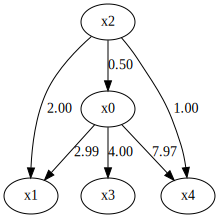

In [20]:
make_dot(model.adjacency_matrix_)

In [46]:
new_df

,case:concept:name,time:timestamp,concept:name
0,0,1.795813,x0
1,1,0.763675,x0
2,2,10.715935,x0
3,3,4.892426,x0
4,4,0.693168,x0
...,...,...,...
499995,99995,74.904619,x4
499996,99996,37.208808,x4
499997,99997,16.713599,x4
499998,99998,21.733419,x4


In [ ]:
func = np.vectorize(datetime.datetime.fromtimestamp)

In [118]:
def convert_table_to_event(df):
    new_df = pd.DataFrame(columns = ['case:concept:name', 'time:timestamp', 'concept:name'])
    for ind1, column1 in enumerate(df.columns):
        size = len(df[column1])
        idx = np.arange(size)
        df_to_append = pd.DataFrame( idx, columns=['case:concept:name'])
        df_to_append['time:timestamp'] = func(df[column1]*(10**7))#df[column1]
        df_to_append['concept:name'] = column1
        new_df = new_df.append(df_to_append, ignore_index=True)
                
    return new_df

In [119]:
new_df = convert_table_to_event(X)
log = log_converter.apply(new_df)

/var/folders/3v/_5sm38dn1mz6tfrqwbfd9kgh0000gn/T/ipykernel_5486/3390243607.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(df_to_append, ignore_index=True)
/var/folders/3v/_5sm38dn1mz6tfrqwbfd9kgh0000gn/T/ipykernel_5486/3390243607.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(df_to_append, ignore_index=True)
/var/folders/3v/_5sm38dn1mz6tfrqwbfd9kgh0000gn/T/ipykernel_5486/3390243607.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(df_to_append, ignore_index=True)
/var/folders/3v/_5sm38dn1mz6tfrqwbfd9kgh0000gn/T/ipykernel_5486/3390243607.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

In [120]:
new_df[new_df['concept:name']=='x1']

,case:concept:name,time:timestamp,concept:name
100000,0,1978-08-18 03:03:36.620652,x1
100001,1,2033-09-10 17:19:04.489149,x1
100002,2,1974-07-16 06:01:00.528306,x1
100003,3,1974-04-28 14:24:13.943250,x1
100004,4,1988-01-15 07:11:50.903725,x1
...,...,...,...
199995,99995,1992-01-25 20:35:22.697928,x1
199996,99996,1998-08-16 00:27:48.780842,x1
199997,99997,1989-03-19 18:06:17.288804,x1
199998,99998,2029-06-20 18:42:41.709597,x1


In [121]:
new_df[new_df['concept:name']=='x2']

,case:concept:name,time:timestamp,concept:name
200000,0,1970-10-26 11:06:08.617341,x2
200001,1,1977-06-29 20:00:48.133166,x2
200002,2,1970-06-04 00:20:18.629036,x2
200003,3,1970-05-22 00:10:58.687791,x2
200004,4,1972-01-19 11:48:42.197468,x2
...,...,...,...
299995,99995,1972-05-06 15:29:00.533485,x2
299996,99996,1973-03-02 11:13:21.460204,x2
299997,99997,1972-03-23 07:09:28.403492,x2
299998,99998,1976-11-10 04:26:41.788816,x2


### alpha on data

In [126]:
new_df.rename(columns={ 'time:timestamp': 'Timestamp', 'case:concept:name':'Id', 'concept:name': 'Source'}, inplace=True)
new_df.to_csv(r'/Users/yuvaldavid/Desktop/file_test.csv', index=False)

In [726]:
#df['Timestap'] = df['Timestamp'] + timedelta(seconds=60)
from datetime import timedelta 
df['Timestamp']= pd.to_datetime(df['Timestamp'])
df.loc[df["Source"] == "End Event", "Timestamp"] = df.loc[df["Source"] == "End Event", "Timestamp"] + timedelta(seconds=60)

In [808]:
eventlog = df.copy()
eventlog = eventlog[eventlog['Type']=='complete']
#eventlog = eventlog.drop(eventlog[eventlog.Id.isin(remove)].index)
del eventlog['Type']

#eventlog = eventlog[eventlog['Source']!= 'Task 1']
### Specify which columns correspond to case (case:concept:name), 
###event (concept:name) and timestamp (time:timestamp) - rename columns in accordance
###with pm4py

eventlog.rename(columns={'Timestamp': 'time:timestamp', 'Id': 'case:concept:name', 'Source': 'concept:name'}, inplace=True)

## Convert to log format
log = log_converter.apply(eventlog)

/var/folders/3v/_5sm38dn1mz6tfrqwbfd9kgh0000gn/T/ipykernel_5355/1747521004.py:5: DeprecatedWarning: apply is deprecated as of 2.2.5 and will be removed in 3.0.0. please use pm4py.visualization.petri_net.algorithm instead
  gviz = pn_visualizer.apply(net, initial_marking, final_marking)


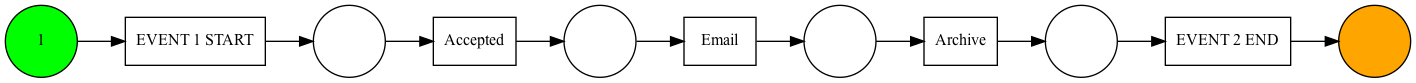

In [823]:
 # alpha miner
net, initial_marking, final_marking = alpha_miner.apply(log)

# Visualise
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

### example to remove edge in the output of alpha miner

In [824]:
temp_1 = 0
temp_2 = 0
for idx,trans in enumerate(net.transitions):
    print(f'we got for {idx} trans:')
    for arc in trans.in_arcs:
        for x in arc.source.in_arcs:
            for y in x.target.out_arcs:
                print(type(x.target))
                print(type(y.target))
                print(x.source.name)
                print(y.target.name)
                if x.source.name == 'Email' and y.target.name =='Archive':  
                    print('bla')
                    temp_1 = x.target
                    temp_2 = y.target

we got for 0 trans:
<class 'pm4py.objects.petri_net.obj.PetriNet.Place'>
<class 'pm4py.objects.petri_net.obj.PetriNet.Transition'>
Archive
EVENT 2 END
we got for 1 trans:
we got for 2 trans:
<class 'pm4py.objects.petri_net.obj.PetriNet.Place'>
<class 'pm4py.objects.petri_net.obj.PetriNet.Transition'>
Email
Archive
bla
we got for 3 trans:
<class 'pm4py.objects.petri_net.obj.PetriNet.Place'>
<class 'pm4py.objects.petri_net.obj.PetriNet.Transition'>
EVENT 1 START
Accepted
we got for 4 trans:
<class 'pm4py.objects.petri_net.obj.PetriNet.Place'>
<class 'pm4py.objects.petri_net.obj.PetriNet.Transition'>
Accepted
Email


In [825]:
import random
import time
from copy import copy, deepcopy

from pm4py.objects.log.obj import Trace, Event
from pm4py.objects.petri import properties
from pm4py.objects.petri import semantics
from pm4py.objects.petri.networkx_graph import create_networkx_directed_graph
from pm4py.objects.petri.obj import PetriNet, Marking
from pm4py.util import xes_constants as xes_util



def remove_arc(net, arc):
    """
    Removes an arc from a Petri net
    Parameters
    ---------------
    net
        Petri net
    arc
        Arc of the Petri net
    Returns
    -------------
    net
        Petri net
    """
    net.arcs.remove(arc)
    arc.source.out_arcs.remove(arc)
    arc.target.in_arcs.remove(arc)

    return net


def remove_transition(net, trans):
    """
    Remove a transition from a Petri net
    Parameters
    ----------
    net
        Petri net
    trans
        Transition to remove
    Returns
    ----------
    net
        Petri net
    """
    if trans in net.transitions:
        in_arcs = trans.in_arcs
        for arc in in_arcs:
            place = arc.source
            place.out_arcs.remove(arc)
            net.arcs.remove(arc)
        out_arcs = trans.out_arcs
        for arc in out_arcs:
            place = arc.target
            place.in_arcs.remove(arc)
            net.arcs.remove(arc)
        net.transitions.remove(trans)
    return net


def remove_place(net, place):
    """
    Remove a place from a Petri net
    Parameters
    -------------
    net
        Petri net
    place
        Place to remove
    Returns
    -------------
    net
        Petri net
    """
    if place in net.places:
        in_arcs = place.in_arcs
        for arc in in_arcs:
            trans = arc.source
            trans.out_arcs.remove(arc)
            net.arcs.remove(arc)
        out_arcs = place.out_arcs
        for arc in out_arcs:
            trans = arc.target
            trans.in_arcs.remove(arc)
            net.arcs.remove(arc)
        net.places.remove(place)
    return net

In [826]:
remove_place(net,temp_1)

places: [ ({'Accepted'}, {'Email'}), ({'Archive'}, {'EVENT 2 END'}), ({'EVENT 1 START'}, {'Accepted'}), end, start ]
transitions: [ (Accepted, 'Accepted'), (Archive, 'Archive'), (EVENT 1 START, 'EVENT 1 START'), (EVENT 2 END, 'EVENT 2 END'), (Email, 'Email') ]
arcs: [ (Accepted, 'Accepted')->({'Accepted'}, {'Email'}), (Archive, 'Archive')->({'Archive'}, {'EVENT 2 END'}), (EVENT 1 START, 'EVENT 1 START')->({'EVENT 1 START'}, {'Accepted'}), (EVENT 2 END, 'EVENT 2 END')->end, ({'Accepted'}, {'Email'})->(Email, 'Email'), ({'Archive'}, {'EVENT 2 END'})->(EVENT 2 END, 'EVENT 2 END'), ({'EVENT 1 START'}, {'Accepted'})->(Accepted, 'Accepted'), start->(EVENT 1 START, 'EVENT 1 START') ]

/var/folders/3v/_5sm38dn1mz6tfrqwbfd9kgh0000gn/T/ipykernel_5355/2261323084.py:1: DeprecatedWarning: apply is deprecated as of 2.2.5 and will be removed in 3.0.0. please use pm4py.visualization.petri_net.algorithm instead
  gviz = pn_visualizer.apply(net, initial_marking, final_marking)


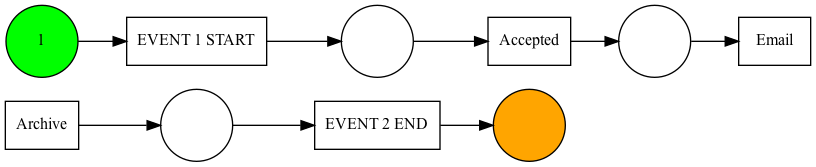

In [827]:
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

In [725]:
import pm4py

tree = pm4py.convert_to_process_tree(net, initial_marking, final_marking)
print(tree)

->( 'EVENT 1 START', 'Accepted', 'Email', 'Archive', 'EVENT 2 END' )


In [727]:
type(net)

pm4py.objects.petri_net.obj.PetriNet

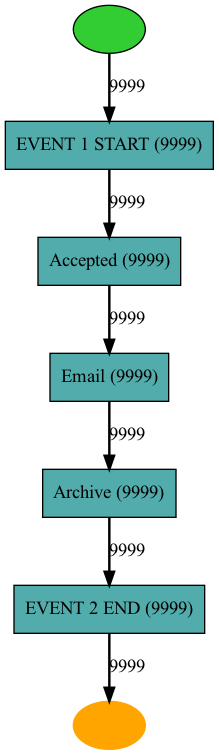

In [722]:
# heuristics miner
heu_net = heuristics_miner.apply_heu(log)

# viz
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

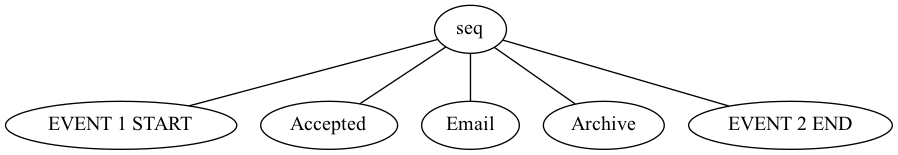

In [723]:
import pm4py
tree = pm4py.discover_process_tree_inductive(log)
pm4py.view_process_tree(tree)